# Event Recognition using Global Feature Descriptors and ML models

In [1]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os

# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = 'C:/Users/Nivedha/Documents/widerdata/images'

bins=8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

In [2]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [3]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [4]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [5]:
global_features = []
labels = []

i, j = 0, 0
k = 0

In [6]:
# num of images per class
images_per_class = 210

In [7]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path + '/'+training_name)
    print(dir)

    # get the current training label
    current_label = training_name
    print(current_label)

    k = 1
    # loop over the images in each sub-folder
    for x in os.listdir(dir):
        if x.endswith(".jpg"):
            file=x
            print(file)
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(dir + '/' + file)
        print(file)
        print(image)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram,fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print ("[STATUS] processed folder: {}".format(current_label))
    j += 1

print ("[STATUS] completed Global Feature Extraction...")

C:/Users/Nivedha/Documents/widerdata/images/0 Parade
0 Parade
0.jpg
0.jpg
[[[171 187 193]
  [ 94 106 112]
  [139 143 148]
  ...
  [166 157 167]
  [158 155 164]
  [178 180 188]]

 [[ 97 112 114]
  [  3  15  17]
  [ 35  38  42]
  ...
  [ 63  58  67]
  [ 67  66  75]
  [125 128 136]]

 [[118 129 127]
  [ 14  20  19]
  [ 27  25  25]
  ...
  [ 86  85  94]
  [ 81  84  92]
  [146 154 161]]

 ...

 [[144 200 195]
  [ 90 146 141]
  [ 97 154 151]
  ...
  [ 87 132 135]
  [ 88 129 132]
  [143 181 185]]

 [[132 186 179]
  [ 86 143 135]
  [ 97 153 148]
  ...
  [ 77 120 123]
  [ 79 117 121]
  [133 168 172]]

 [[152 207 198]
  [121 175 168]
  [136 190 183]
  ...
  [135 176 179]
  [133 170 174]
  [179 214 218]]]
1.jpg
1.jpg
[[[ 57  45  51]
  [ 58  47  49]
  [ 60  52  45]
  ...
  [246 241 242]
  [226 221 222]
  [183 177 178]]

 [[ 60  48  54]
  [ 61  50  52]
  [ 61  53  46]
  ...
  [251 246 247]
  [239 234 235]
  [210 204 205]]

 [[ 62  51  54]
  [ 60  50  50]
  [ 59  52  43]
  ...
  [250 245 246]
  [242

116.jpg
116.jpg
[[[184 185 181]
  [184 185 181]
  [184 185 181]
  ...
  [196 185 165]
  [196 185 165]
  [196 185 165]]

 [[182 182 176]
  [182 182 176]
  [182 182 176]
  ...
  [194 183 163]
  [194 183 163]
  [194 183 163]]

 [[183 180 172]
  [183 180 172]
  [183 180 172]
  ...
  [194 183 163]
  [194 183 163]
  [194 183 163]]

 ...

 [[ 80  38  15]
  [ 80  38  15]
  [ 64  22   0]
  ...
  [ 50  15   1]
  [ 47  12   0]
  [ 69  30  15]]

 [[ 63  22   0]
  [ 88  46  23]
  [ 72  30   7]
  ...
  [ 43  17   5]
  [ 51  25  11]
  [ 81  55  38]]

 [[ 67  26   3]
  [ 69  27   4]
  [ 72  28   5]
  ...
  [ 29  14   5]
  [ 24   8   0]
  [ 95  84  64]]]
117.jpg
117.jpg
[[[253 240 196]
  [253 240 196]
  [253 240 196]
  ...
  [254 211 162]
  [254 211 162]
  [254 211 162]]

 [[253 240 196]
  [253 240 196]
  [253 240 196]
  ...
  [254 211 162]
  [254 211 162]
  [254 211 162]]

 [[253 240 196]
  [253 240 196]
  [253 240 196]
  ...
  [254 211 162]
  [254 211 162]
  [254 211 162]]

 ...

 [[ 96 101  92]
  [ 

131.jpg
131.jpg
[[[209 150 104]
  [202 146  99]
  [198 144  97]
  ...
  [203 151 105]
  [203 151 105]
  [203 151 105]]

 [[211 152 106]
  [204 148 101]
  [199 145  98]
  ...
  [203 151 105]
  [203 151 105]
  [203 151 105]]

 [[212 156 109]
  [207 151 104]
  [202 148 101]
  ...
  [203 151 105]
  [203 151 105]
  [203 151 105]]

 ...

 [[ 17  12  13]
  [ 24  19  20]
  [ 32  27  28]
  ...
  [159 162 166]
  [158 161 165]
  [158 161 165]]

 [[ 36  31  32]
  [ 56  51  52]
  [ 80  75  76]
  ...
  [161 164 168]
  [159 162 166]
  [158 161 165]]

 [[100  98  98]
  [129 127 127]
  [144 142 142]
  ...
  [163 166 170]
  [166 169 173]
  [168 171 175]]]
132.jpg
132.jpg
[[[ 14  20  19]
  [ 13  19  18]
  [  9  15  14]
  ...
  [ 79 138 164]
  [ 51 119 148]
  [ 93 167 201]]

 [[ 14  20  19]
  [ 13  19  18]
  [  9  15  14]
  ...
  [105 163 192]
  [ 80 144 178]
  [108 179 216]]

 [[ 14  20  19]
  [ 14  20  19]
  [ 10  16  15]
  ...
  [113 167 202]
  [ 93 154 194]
  [107 175 218]]

 ...

 [[ 36  40  51]
  [ 

16.jpg
16.jpg
[[[ 24  53  68]
  [ 10  42  55]
  [ 31  70  79]
  ...
  [ 81  70  66]
  [ 82  71  67]
  [ 72  61  57]]

 [[ 12  43  58]
  [ 34  68  81]
  [  0  34  43]
  ...
  [ 81  70  66]
  [ 84  73  69]
  [ 70  59  55]]

 [[  0  35  49]
  [ 36  74  86]
  [  0  30  39]
  ...
  [ 74  63  59]
  [ 86  75  71]
  [ 86  75  71]]

 ...

 [[  8  52  45]
  [  8  49  44]
  [ 70 110 105]
  ...
  [119 112  92]
  [113 107  84]
  [100  92  69]]

 [[ 15  57  50]
  [ 12  53  46]
  [ 73 111 105]
  ...
  [117 111  92]
  [100  95  74]
  [ 77  71  48]]

 [[  7  48  41]
  [ 26  64  58]
  [ 88 124 118]
  ...
  [117 113  94]
  [ 74  68  49]
  [ 61  56  35]]]
160.jpg
160.jpg
[[[ 68 157 238]
  [ 69 158 238]
  [ 72 164 237]
  ...
  [ 23  43  78]
  [ 21  43  79]
  [ 18  42  78]]

 [[ 77 163 245]
  [ 76 163 243]
  [ 76 165 239]
  ...
  [ 23  42  77]
  [ 19  39  74]
  [ 15  37  73]]

 [[ 80 162 244]
  [ 77 159 240]
  [ 74 160 236]
  ...
  [ 23  40  73]
  [ 19  38  73]
  [ 16  36  71]]

 ...

 [[ 14  23  43]
  [  9

247.jpg
247.jpg
[[[130  59  55]
  [ 99  35  31]
  [ 81  29  23]
  ...
  [ 39  94 103]
  [ 38  99 109]
  [ 70 139 149]]

 [[138  67  63]
  [124  60  56]
  [ 86  34  28]
  ...
  [ 64 115 125]
  [ 88 147 157]
  [123 187 198]]

 [[115  44  40]
  [128  64  59]
  [108  53  48]
  ...
  [ 80 126 137]
  [110 162 174]
  [130 188 200]]

 ...

 [[ 42  24  25]
  [ 39  21  20]
  [ 46  30  23]
  ...
  [ 69  61  62]
  [ 11   6   7]
  [  9   8  10]]

 [[ 46  28  29]
  [ 42  24  23]
  [ 41  25  18]
  ...
  [ 64  53  55]
  [ 15   9  10]
  [ 18  13  15]]

 [[ 34  18  19]
  [ 36  18  17]
  [ 28  12   5]
  ...
  [ 42  29  31]
  [ 38  27  29]
  [ 18  11  14]]]
248.jpg
248.jpg
[[[170 174 179]
  [178 182 187]
  [184 188 193]
  ...
  [108 106  96]
  [107 105  95]
  [110 108  98]]

 [[178 182 187]
  [184 188 193]
  [187 191 196]
  ...
  [116 113 105]
  [115 112 104]
  [115 112 104]]

 [[185 189 194]
  [189 193 198]
  [190 194 199]
  ...
  [109 106  98]
  [108 105  97]
  [106 103  95]]

 ...

 [[ 54  56  56]
  [ 

269.jpg
269.jpg
[[[ 60  73  57]
  [ 61  74  58]
  [ 50  66  49]
  ...
  [  3  24   9]
  [  1  20   5]
  [  1  18   4]]

 [[ 47  58  42]
  [ 44  57  41]
  [ 44  60  43]
  ...
  [  8  27  12]
  [  6  25  10]
  [  7  24  10]]

 [[ 36  46  30]
  [ 30  41  25]
  [ 38  51  35]
  ...
  [  7  26  11]
  [  9  28  13]
  [ 11  28  14]]

 ...

 [[ 93  84  75]
  [ 91  82  73]
  [ 90  81  72]
  ...
  [ 28  36  43]
  [ 28  36  43]
  [ 28  36  43]]

 [[ 94  83  75]
  [ 95  84  76]
  [ 96  85  77]
  ...
  [ 34  41  44]
  [ 33  39  44]
  [ 33  39  44]]

 [[105  89  82]
  [108  92  85]
  [110  94  87]
  ...
  [ 53  58  59]
  [ 52  57  60]
  [ 50  55  58]]]
27.jpg
27.jpg
[[[111 111  95]
  [164 164 148]
  [ 43  44  28]
  ...
  [238 238 232]
  [240 240 234]
  [238 238 232]]

 [[ 51  51  35]
  [ 77  78  62]
  [163 164 148]
  ...
  [248 248 242]
  [248 248 242]
  [242 242 236]]

 [[ 94  95  79]
  [118 119 103]
  [235 238 222]
  ...
  [237 237 231]
  [240 240 234]
  [241 241 235]]

 ...

 [[ 86  92  69]
  [110

290.jpg
[[[255 255 250]
  [255 255 250]
  [255 255 250]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 [[255 255 250]
  [255 255 250]
  [255 255 251]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 [[255 255 250]
  [255 255 251]
  [254 255 251]
  ...
  [252 252 252]
  [252 252 252]
  [252 252 252]]

 ...

 [[231 241 241]
  [241 251 251]
  [243 253 253]
  ...
  [ 62  66  67]
  [ 53  57  58]
  [ 57  61  62]]

 [[236 246 246]
  [239 249 249]
  [241 251 251]
  ...
  [138 143 144]
  [ 92  96  97]
  [ 57  61  62]]

 [[241 251 251]
  [234 244 244]
  [235 245 245]
  ...
  [103 108 109]
  [ 83  88  89]
  [ 70  75  76]]]
291.jpg
291.jpg
[[[124 122 121]
  [126 124 123]
  [129 127 126]
  ...
  [163 164 168]
  [132 132 132]
  [ 91  90  86]]

 [[130 128 127]
  [132 130 129]
  [134 132 131]
  ...
  [ 77  77  77]
  [ 85  83  82]
  [105 102  97]]

 [[133 131 130]
  [135 133 132]
  [137 135 134]
  ...
  [174 173 169]
  [200 198 190]
  [192 190 180]]

 ...

 [[227 255 253]
  [230 251 2

49.jpg
49.jpg
[[[114 130 136]
  [122 138 144]
  [107 123 129]
  ...
  [106 113 132]
  [101 108 127]
  [ 77  84 103]]

 [[ 70  86  92]
  [ 78  94 100]
  [ 77  93  99]
  ...
  [102 112 130]
  [ 95 107 125]
  [ 78  90 108]]

 [[ 63  76  84]
  [ 69  82  90]
  [ 82  95 103]
  ...
  [114 130 147]
  [110 126 143]
  [103 119 136]]

 ...

 [[230 236 235]
  [230 236 235]
  [231 237 236]
  ...
  [213 208 209]
  [212 207 208]
  [211 206 207]]

 [[229 235 234]
  [229 235 234]
  [231 237 236]
  ...
  [213 208 209]
  [212 207 208]
  [212 207 208]]

 [[228 234 233]
  [229 235 234]
  [231 237 236]
  ...
  [212 207 208]
  [212 207 208]
  [212 207 208]]]
5.jpg
5.jpg
[[[113  77  13]
  [ 96  60   0]
  [108  73   7]
  ...
  [ 60  24   6]
  [ 58  22   6]
  [ 54  20   4]]

 [[145 108  46]
  [131  94  32]
  [118  82  18]
  ...
  [ 60  26   3]
  [ 63  29   6]
  [ 69  36  16]]

 [[146 110  50]
  [136 100  40]
  [114  79  16]
  ...
  [ 54  22   0]
  [ 62  32   3]
  [ 85  55  26]]

 ...

 [[153 159 136]
  [179 184

61.jpg
61.jpg
[[[117 119 100]
  [ 87  89  69]
  [170 171 151]
  ...
  [210 197 181]
  [210 197 181]
  [209 196 180]]

 [[116 118  99]
  [ 94  96  77]
  [180 180 162]
  ...
  [209 196 180]
  [208 195 179]
  [208 195 179]]

 [[ 85  85  71]
  [ 95  95  79]
  [181 181 165]
  ...
  [208 195 179]
  [207 194 178]
  [207 194 178]]

 ...

 [[128 134 129]
  [127 133 128]
  [127 133 128]
  ...
  [122 127 128]
  [121 126 127]
  [119 124 125]]

 [[126 132 127]
  [126 132 127]
  [126 132 127]
  ...
  [122 127 128]
  [121 126 127]
  [119 124 125]]

 [[125 131 126]
  [125 131 126]
  [126 132 127]
  ...
  [118 123 124]
  [119 124 125]
  [119 124 125]]]
62.jpg
62.jpg
[[[ 90  96  91]
  [ 79  85  80]
  [ 66  72  67]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 77  83  78]
  [ 71  77  72]
  [ 64  70  65]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 63  69  64]
  [ 63  69  64]
  [ 64  70  65]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 55  23 118]
  [ 61  

77.jpg
77.jpg
[[[ 92 134 123]
  [ 92 134 123]
  [ 96 136 125]
  ...
  [ 87 121 120]
  [ 96 130 130]
  [106 139 142]]

 [[ 99 140 125]
  [ 99 140 125]
  [102 141 126]
  ...
  [ 79 114 110]
  [ 81 115 114]
  [ 85 119 119]]

 [[106 144 126]
  [104 142 124]
  [106 142 125]
  ...
  [ 81 117 111]
  [ 80 116 110]
  [ 80 115 111]]

 ...

 [[112 112 112]
  [114 114 114]
  [116 116 116]
  ...
  [ 49  47  47]
  [ 41  39  39]
  [ 30  28  28]]

 [[117 117 117]
  [118 118 118]
  [119 119 119]
  ...
  [ 51  49  49]
  [ 45  43  43]
  [ 34  32  32]]

 [[116 116 116]
  [113 113 113]
  [118 118 118]
  ...
  [ 48  46  46]
  [ 41  39  39]
  [ 25  23  23]]]
78.jpg
78.jpg
[[[ 99  92  77]
  [ 99  92  77]
  [ 99  92  77]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 [[ 99  92  77]
  [ 99  92  77]
  [100  93  78]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 [[ 99  92  77]
  [100  93  78]
  [100  93  78]
  ...
  [  1   1   1]
  [  1   1   1]
  [  1   1   1]]

 ...

 [[ 26  29  67]
  [ 25  

90.jpg
90.jpg
[[[252 201 161]
  [253 202 162]
  [252 203 163]
  ...
  [252 214 172]
  [251 213 171]
  [251 213 171]]

 [[252 201 161]
  [253 202 162]
  [252 203 163]
  ...
  [251 216 173]
  [252 214 172]
  [251 213 171]]

 [[253 203 161]
  [254 204 162]
  [255 205 163]
  ...
  [251 216 173]
  [250 215 172]
  [252 214 172]]

 ...

 [[137 151 163]
  [136 150 162]
  [136 150 162]
  ...
  [137 149 161]
  [140 152 164]
  [135 149 161]]

 [[144 157 171]
  [137 150 164]
  [133 146 160]
  ...
  [137 151 163]
  [137 151 163]
  [132 146 158]]

 [[137 150 164]
  [140 153 167]
  [141 154 168]
  ...
  [129 143 155]
  [126 140 152]
  [126 142 154]]]
91.jpg
91.jpg
[[[128 136 143]
  [133 141 148]
  [139 147 154]
  ...
  [192 209 212]
  [193 210 213]
  [193 210 213]]

 [[130 137 146]
  [134 142 149]
  [140 148 155]
  ...
  [193 210 213]
  [194 211 214]
  [194 211 214]]

 [[131 140 149]
  [133 142 151]
  [137 147 154]
  ...
  [194 211 214]
  [195 212 215]
  [195 212 215]]

 ...

 [[167 150 164]
  [165 1

111.jpg
111.jpg
[[[215 216 207]
  [218 219 210]
  [222 223 214]
  ...
  [230 227 222]
  [230 227 222]
  [230 227 222]]

 [[214 215 206]
  [217 218 209]
  [221 222 213]
  ...
  [228 225 220]
  [228 225 220]
  [228 225 220]]

 [[214 215 206]
  [217 218 209]
  [221 222 213]
  ...
  [227 224 219]
  [227 224 219]
  [227 224 219]]

 ...

 [[ 54  48  49]
  [ 60  54  55]
  [ 64  58  59]
  ...
  [251 253 253]
  [246 248 248]
  [253 255 255]]

 [[ 54  48  49]
  [ 60  54  55]
  [ 64  58  59]
  ...
  [238 240 240]
  [246 248 248]
  [243 245 245]]

 [[ 56  50  51]
  [ 59  53  54]
  [ 63  57  58]
  ...
  [246 248 248]
  [246 248 248]
  [245 247 247]]]
112.jpg
112.jpg
[[[ 32  60  94]
  [ 30  58  92]
  [ 24  52  86]
  ...
  [ 17  43  57]
  [ 17  43  57]
  [ 13  39  53]]

 [[ 31  59  93]
  [ 30  58  92]
  [ 26  54  88]
  ...
  [ 17  43  57]
  [ 17  43  57]
  [ 13  39  53]]

 [[ 36  64  98]
  [ 33  61  95]
  [ 27  55  89]
  ...
  [ 18  44  58]
  [ 18  44  58]
  [ 14  40  54]]

 ...

 [[ 20  31  53]
  [ 

15.jpg
15.jpg
[[[241 244 229]
  [242 245 230]
  [242 245 230]
  ...
  [255 249 246]
  [255 249 246]
  [255 248 245]]

 [[241 244 229]
  [242 245 230]
  [244 246 234]
  ...
  [252 245 242]
  [252 245 242]
  [251 244 241]]

 [[244 247 232]
  [246 248 236]
  [250 252 240]
  ...
  [250 242 242]
  [250 242 242]
  [250 242 242]]

 ...

 [[189 212 214]
  [203 226 228]
  [213 236 238]
  ...
  [127 180 183]
  [114 171 168]
  [ 96 156 148]]

 [[189 211 216]
  [200 222 227]
  [206 228 233]
  ...
  [193 233 245]
  [176 220 227]
  [183 228 231]]

 [[203 225 231]
  [209 231 237]
  [209 231 237]
  ...
  [193 220 240]
  [175 206 221]
  [190 222 235]]]
150.jpg
150.jpg
[[[253 246 207]
  [201 187 151]
  [202 177 145]
  ...
  [241 250 237]
  [241 250 237]
  [241 251 239]]

 [[254 245 207]
  [198 182 145]
  [198 171 137]
  ...
  [245 254 241]
  [245 254 241]
  [244 254 242]]

 [[255 248 208]
  [198 179 142]
  [194 166 132]
  ...
  [242 251 238]
  [241 250 237]
  [237 247 235]]

 ...

 [[244 250 239]
  [240

168.jpg
[[[ 71  61  51]
  [ 70  60  50]
  [ 68  58  48]
  ...
  [251 250 254]
  [252 251 255]
  [255 254 255]]

 [[ 70  60  50]
  [ 69  59  49]
  [ 68  58  48]
  ...
  [255 254 255]
  [252 251 255]
  [255 254 255]]

 [[ 70  60  50]
  [ 69  59  49]
  [ 68  58  48]
  ...
  [255 254 255]
  [245 244 246]
  [250 249 251]]

 ...

 [[255 250 254]
  [255 255 255]
  [230 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 245 254]
  [255 252 255]
  [232 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 243 255]
  [255 249 255]
  [236 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
17.jpg
17.jpg
[[[ 53  68  77]
  [ 53  68  77]
  [ 53  68  77]
  ...
  [ 67  83  95]
  [ 69  85  97]
  [ 70  86  98]]

 [[ 52  67  76]
  [ 52  67  76]
  [ 52  67  76]
  ...
  [ 77  93 105]
  [ 77  93 105]
  [ 77  93 105]]

 [[ 56  71  80]
  [ 56  71  80]
  [ 56  71  80]
  ...
  [ 78  94 107]
  [ 76  92 105]
  [ 76  92 105]]

 ...

 [[ 98 110 122]
  [ 98 110 122

189.jpg
189.jpg
[[[128 141 157]
  [134 147 163]
  [138 151 167]
  ...
  [ 65  85 102]
  [ 65  85 102]
  [ 64  84 101]]

 [[131 144 160]
  [135 148 164]
  [136 149 165]
  ...
  [ 66  89 105]
  [ 66  89 105]
  [ 66  89 105]]

 [[135 148 164]
  [136 149 165]
  [133 148 164]
  ...
  [ 62  88 102]
  [ 62  88 102]
  [ 61  87 101]]

 ...

 [[ 18  20  28]
  [ 17  19  27]
  [ 15  18  23]
  ...
  [ 19  21  32]
  [ 19  21  32]
  [ 18  20  31]]

 [[ 18  20  28]
  [ 17  19  27]
  [ 15  18  23]
  ...
  [ 18  20  31]
  [ 18  20  31]
  [ 18  20  31]]

 [[ 18  20  28]
  [ 17  19  27]
  [ 15  18  23]
  ...
  [ 18  20  31]
  [ 18  20  31]
  [ 17  19  30]]]
19.jpg
19.jpg
[[[126 170 199]
  [126 170 199]
  [126 170 199]
  ...
  [137 178 203]
  [137 178 203]
  [136 177 202]]

 [[126 170 199]
  [126 170 199]
  [126 170 199]
  ...
  [137 178 203]
  [137 178 203]
  [137 178 203]]

 [[127 171 200]
  [127 171 200]
  [127 171 200]
  ...
  [138 179 204]
  [137 178 203]
  [137 178 203]]

 ...

 [[ 96 158 212]
  [ 96

279.jpg
279.jpg
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 254 255]
  [255 254 255]
  [255 254 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 254 255]
  [255 254 255]
  [255 254 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
28.jpg
28.jpg
[[[ 50  48  40]
  [ 37  37  31]
  [ 66  70  65]
  ...
  [ 88  83  84]
  [  4   0   0]
  [ 28  23  24]]

 [[ 51  48  40]
  [ 38  35  30]
  [ 57  58  54]
  ...
  [122 117 118]
  [ 32  27  28]
  [ 31  26  27]]

 [[ 47  39  32]
  [ 41  35  30]
  [ 55  52  48]
  ...
  [154 149 150]
  [ 59  54  55]
  [ 26  21  22]]

 ...

 [[ 30  14  15]
  [ 32

301.jpg
301.jpg
[[[252 240 216]
  [251 239 215]
  [250 238 214]
  ...
  [223 196 169]
  [222 195 168]
  [222 193 166]]

 [[252 240 216]
  [252 240 216]
  [251 239 215]
  ...
  [226 199 172]
  [229 200 173]
  [230 201 174]]

 [[253 241 217]
  [253 241 217]
  [252 240 216]
  ...
  [233 205 175]
  [235 207 177]
  [237 207 178]]

 ...

 [[251 255 255]
  [251 255 255]
  [251 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[251 255 255]
  [251 255 255]
  [251 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[251 255 255]
  [251 255 255]
  [251 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
303.jpg
303.jpg
[[[223 228 219]
  [224 229 220]
  [224 229 220]
  ...
  [205 209 180]
  [192 196 167]
  [194 199 168]]

 [[224 232 222]
  [223 231 221]
  [222 230 220]
  ...
  [189 192 166]
  [196 200 171]
  [184 188 159]]

 [[185 196 188]
  [181 192 184]
  [178 189 181]
  ...
  [158 161 136]
  [187 190 164]
  [182 185 159]]

 ...

 [[ 65 119 106]
  [ 

33.jpg
33.jpg
[[[234 246 255]
  [194 206 218]
  [170 183 197]
  ...
  [146 165 173]
  [146 165 173]
  [145 164 172]]

 [[243 253 255]
  [197 209 219]
  [165 177 189]
  ...
  [146 165 173]
  [145 164 172]
  [145 164 172]]

 [[244 253 255]
  [194 205 213]
  [165 175 185]
  ...
  [146 165 173]
  [145 164 172]
  [145 164 172]]

 ...

 [[253 255 255]
  [204 206 206]
  [164 164 164]
  ...
  [ 65  77 113]
  [ 63  79 122]
  [ 62  80 127]]

 [[252 254 254]
  [198 200 200]
  [172 172 172]
  ...
  [ 61  75 117]
  [ 69  85 131]
  [ 71  88 137]]

 [[251 253 253]
  [195 197 197]
  [168 168 168]
  ...
  [ 59  75 118]
  [ 70  86 133]
  [ 71  89 136]]]
331.jpg
331.jpg
[[[239 239 239]
  [239 239 239]
  [238 238 238]
  ...
  [238 238 238]
  [238 238 238]
  [238 238 238]]

 [[239 239 239]
  [239 239 239]
  [238 238 238]
  ...
  [238 238 238]
  [238 238 238]
  [238 238 238]]

 [[239 239 239]
  [239 239 239]
  [238 238 238]
  ...
  [238 238 238]
  [238 238 238]
  [238 238 238]]

 ...

 [[189 195 200]
  [189

36.jpg
[[[136 213 205]
  [149 226 218]
  [138 217 208]
  ...
  [120 196 185]
  [128 204 193]
  [132 208 197]]

 [[133 210 202]
  [136 213 205]
  [123 202 193]
  ...
  [117 193 182]
  [126 202 191]
  [130 206 195]]

 [[145 224 215]
  [137 216 207]
  [126 205 196]
  ...
  [117 193 182]
  [125 201 190]
  [128 204 193]]

 ...

 [[113 193 186]
  [110 190 183]
  [108 188 181]
  ...
  [ 58 121 112]
  [ 56 119 110]
  [ 52 115 106]]

 [[115 195 190]
  [118 198 193]
  [118 198 193]
  ...
  [ 60 123 114]
  [ 56 119 110]
  [ 51 114 105]]

 [[ 97 177 172]
  [105 185 180]
  [106 186 181]
  ...
  [ 60 123 114]
  [ 56 119 110]
  [ 52 115 106]]]
37.jpg
37.jpg
[[[187 114  56]
  [187 114  56]
  [187 114  56]
  ...
  [198 139 100]
  [198 139 100]
  [197 138  99]]

 [[189 116  58]
  [189 116  58]
  [189 116  58]
  ...
  [200 141 102]
  [199 140 101]
  [199 140 101]]

 [[191 118  60]
  [191 118  60]
  [191 118  60]
  ...
  [201 142 103]
  [200 141 102]
  [199 140 101]]

 ...

 [[ 35  53  40]
  [ 35  55  42]

59.jpg
59.jpg
[[[154 153 157]
  [  2   1   5]
  [ 11  10  14]
  ...
  [ 20  22  16]
  [ 28  29  25]
  [ 11  14  12]]

 [[148 147 151]
  [  0   0   3]
  [ 13  12  16]
  ...
  [  9  10   6]
  [ 21  22  18]
  [ 11  14  12]]

 [[148 147 149]
  [  3   2   4]
  [ 23  20  22]
  ...
  [  3   4   0]
  [ 16  17  13]
  [  8  11   9]]

 ...

 [[166 156 149]
  [  8   1   0]
  [ 32  28  27]
  ...
  [ 18  13  14]
  [ 18  13  14]
  [ 18  13  14]]

 [[167 157 150]
  [  9   3   0]
  [ 32  28  27]
  ...
  [ 17  12  13]
  [ 17  12  13]
  [ 17  12  13]]

 [[166 158 151]
  [ 10   4   0]
  [ 33  29  28]
  ...
  [ 17  12  13]
  [ 17  12  13]
  [ 18  13  14]]]
6.jpg
6.jpg
[[[222 227 226]
  [215 220 219]
  [222 227 226]
  ...
  [  4   0   0]
  [  5   1   0]
  [  6   1   0]]

 [[219 224 223]
  [215 220 219]
  [223 228 227]
  ...
  [  5   3   2]
  [  6   2   1]
  [  6   3   0]]

 [[218 223 222]
  [214 219 218]
  [219 224 223]
  ...
  [ 16  14  14]
  [  6   2   1]
  [  6   2   1]]

 ...

 [[ 96 164 199]
  [ 75 143

72.jpg
72.jpg
[[[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [ 54 122 169]
  [ 52 120 167]
  [ 40 111 161]]

 [[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [ 55 110 115]
  [ 56 111 116]
  [ 78 135 144]]

 [[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [166 212 190]
  [146 192 170]
  [194 242 224]]

 ...

 [[ 51 100 144]
  [ 34  85 125]
  [ 46 100 131]
  ...
  [ 41  97 146]
  [ 77 136 182]
  [ 57 118 162]]

 [[ 57 107 153]
  [ 52 104 144]
  [ 49 106 137]
  ...
  [ 48 112 153]
  [ 46 110 151]
  [ 47 113 154]]

 [[ 57 109 155]
  [ 81 138 177]
  [ 75 135 165]
  ...
  [ 15  87 121]
  [ 41 112 149]
  [ 27  98 136]]]
73.jpg
73.jpg
[[[215 220 219]
  [215 220 219]
  [215 220 219]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[215 220 219]
  [216 221 220]
  [216 221 220]
  ...
  [252 252 252]
  [253 253 253]
  [255 255 255]]

 [[216 221 220]
  [216 221 220]
  [216 221 220]
  ...
  [252 252 252]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 72  91  99]
  [ 36  

91.jpg
91.jpg
[[[118 142 160]
  [119 143 161]
  [142 167 183]
  ...
  [168 172 177]
  [161 164 169]
  [171 171 177]]

 [[120 144 162]
  [120 144 162]
  [142 167 183]
  ...
  [171 175 180]
  [162 165 170]
  [170 170 176]]

 [[123 147 165]
  [121 145 163]
  [141 166 182]
  ...
  [173 177 182]
  [162 165 170]
  [167 167 173]]

 ...

 [[220 253 255]
  [227 250 252]
  [248 255 255]
  ...
  [255 255 255]
  [254 254 254]
  [253 253 253]]

 [[220 255 255]
  [220 251 254]
  [237 249 253]
  ...
  [255 255 255]
  [253 253 253]
  [253 253 253]]

 [[250 255 254]
  [252 254 254]
  [252 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
92.jpg
92.jpg
[[[  7  13  12]
  [  6  12  11]
  [  7  13  12]
  ...
  [ 61  61  45]
  [ 57  57  41]
  [ 55  55  37]]

 [[  8  14  13]
  [  5  11  10]
  [  4  10   9]
  ...
  [ 68  68  52]
  [ 64  64  48]
  [ 62  62  46]]

 [[  9  15  14]
  [  7  13  12]
  [  4  10   9]
  ...
  [ 77  76  62]
  [ 74  74  58]
  [ 71  71  55]]

 ...

 [[ 90 101  99]
  [ 90 1

11.jpg
[[[178 167 153]
  [188 177 163]
  [200 191 178]
  ...
  [ 12  18  17]
  [ 12  18  17]
  [ 12  18  17]]

 [[184 173 159]
  [192 181 167]
  [204 195 182]
  ...
  [ 11  17  16]
  [ 12  18  17]
  [ 12  18  17]]

 [[193 182 168]
  [196 185 171]
  [205 196 183]
  ...
  [ 11  17  16]
  [ 12  18  17]
  [ 11  17  16]]

 ...

 [[ 93 121 138]
  [ 96 124 141]
  [ 99 127 144]
  ...
  [133 160 174]
  [126 153 167]
  [119 146 160]]

 [[ 91 119 136]
  [ 91 119 136]
  [ 91 119 136]
  ...
  [134 161 175]
  [126 153 167]
  [118 145 159]]

 [[ 89 117 134]
  [ 87 115 132]
  [ 85 113 130]
  ...
  [138 165 179]
  [137 164 178]
  [136 163 177]]]
110.jpg
110.jpg
[[[ 98  93  68]
  [ 97  92  71]
  [105 103  85]
  ...
  [220 211 202]
  [220 211 202]
  [220 211 202]]

 [[106  95  68]
  [104  94  70]
  [113 106  87]
  ...
  [220 211 202]
  [220 211 202]
  [220 211 202]]

 [[106  86  55]
  [103  86  59]
  [115 101  79]
  ...
  [220 210 203]
  [220 210 203]
  [220 210 203]]

 ...

 [[ 92  92  86]
  [ 98  98  9

124.jpg
[[[44 49 50]
  [46 51 52]
  [41 46 47]
  ...
  [43 43 43]
  [38 38 38]
  [38 38 38]]

 [[43 48 49]
  [45 50 51]
  [41 46 47]
  ...
  [44 44 44]
  [41 41 41]
  [40 40 40]]

 [[43 48 49]
  [46 51 52]
  [43 48 49]
  ...
  [46 46 46]
  [46 46 46]
  [44 44 44]]

 ...

 [[16 19 17]
  [23 24 20]
  [15 16 12]
  ...
  [17 17 17]
  [16 16 16]
  [13 13 13]]

 [[17 20 18]
  [24 27 25]
  [16 17 13]
  ...
  [19 19 19]
  [17 17 17]
  [10 10 10]]

 [[15 17 17]
  [22 25 23]
  [18 19 17]
  ...
  [16 16 16]
  [16 16 16]
  [16 16 16]]]
125.jpg
125.jpg
[[[31 33 34]
  [31 33 34]
  [29 33 34]
  ...
  [11  4 11]
  [11  4 11]
  [10  2 12]]

 [[31 33 34]
  [31 33 34]
  [29 33 34]
  ...
  [12  4 11]
  [12  4 11]
  [12  3 13]]

 [[29 33 34]
  [29 33 34]
  [29 33 34]
  ...
  [11  3 10]
  [12  4 11]
  [12  3 13]]

 ...

 [[13  5  6]
  [13  5  6]
  [14  5  8]
  ...
  [10  3  6]
  [12  3  6]
  [14  3  6]]

 [[12  4  4]
  [13  5  5]
  [15  7  8]
  ...
  [ 9  0  3]
  [11  0  3]
  [14  0  4]]

 [[16  7  4]
  [16

14.jpg
14.jpg
[[[ 54  67  81]
  [ 40  53  67]
  [ 55  68  82]
  ...
  [247 254 251]
  [248 253 251]
  [245 250 248]]

 [[ 56  69  83]
  [ 47  60  74]
  [ 55  68  82]
  ...
  [249 255 250]
  [247 252 250]
  [242 247 245]]

 [[ 57  70  84]
  [ 50  63  77]
  [ 52  65  79]
  ...
  [246 252 247]
  [239 245 240]
  [226 231 229]]

 ...

 [[ 43  50  53]
  [ 42  49  52]
  [ 41  48  51]
  ...
  [ 42  46  47]
  [ 40  44  45]
  [ 42  46  47]]

 [[ 45  52  55]
  [ 43  50  53]
  [ 40  47  50]
  ...
  [ 44  48  49]
  [ 44  48  49]
  [ 44  48  49]]

 [[ 45  52  55]
  [ 43  50  53]
  [ 40  47  50]
  ...
  [ 44  48  49]
  [ 44  48  49]
  [ 44  48  49]]]
140.jpg
140.jpg
[[[121  72  50]
  [121  72  50]
  [121  72  50]
  ...
  [ 80  43  23]
  [ 80  43  23]
  [ 80  43  23]]

 [[121  72  50]
  [121  72  50]
  [121  72  50]
  ...
  [ 80  43  23]
  [ 80  43  23]
  [ 80  43  23]]

 [[122  73  51]
  [122  73  51]
  [122  73  51]
  ...
  [ 81  44  24]
  [ 81  44  24]
  [ 81  44  24]]

 ...

 [[ 14  14  38]
  [ 14

151.jpg
151.jpg
[[[138 138 138]
  [130 130 130]
  [139 139 139]
  ...
  [179 187 177]
  [ 91  99  89]
  [ 12  18   7]]

 [[111 111 111]
  [ 52  52  52]
  [ 16  16  16]
  ...
  [159 167 157]
  [160 168 158]
  [152 158 147]]

 [[ 88  88  88]
  [ 27  27  27]
  [  0   0   0]
  ...
  [159 167 157]
  [194 202 192]
  [220 228 218]]

 ...

 [[ 20  33  35]
  [ 23  38  41]
  [ 13  28  31]
  ...
  [173 187 193]
  [177 189 195]
  [180 192 198]]

 [[  9  21  23]
  [ 25  37  41]
  [ 31  43  47]
  ...
  [173 186 194]
  [174 187 195]
  [177 188 196]]

 [[ 16  25  28]
  [ 20  31  35]
  [ 26  37  41]
  ...
  [173 186 194]
  [173 186 194]
  [174 187 195]]]
152.jpg
152.jpg
[[[17 19 19]
  [21 23 23]
  [19 24 23]
  ...
  [73 74 70]
  [70 71 67]
  [66 67 63]]

 [[17 20 18]
  [21 23 23]
  [20 22 22]
  ...
  [73 74 70]
  [71 72 68]
  [66 67 63]]

 [[19 20 18]
  [22 22 22]
  [20 22 22]
  ...
  [74 75 71]
  [72 73 69]
  [67 68 64]]

 ...

 [[ 0  0  4]
  [ 0  1  2]
  [ 0  0  1]
  ...
  [ 0  1  5]
  [ 4  7 11]
  [

21.jpg
[[[ 76 117 110]
  [ 91 132 125]
  [ 49  87  81]
  ...
  [103 110 119]
  [157 167 174]
  [207 220 222]]

 [[110 152 145]
  [105 147 140]
  [ 48  90  83]
  ...
  [220 227 236]
  [193 203 210]
  [135 148 150]]

 [[ 49  96  88]
  [ 81 128 120]
  [ 70 117 109]
  ...
  [109 116 125]
  [ 69  80  84]
  [ 48  61  63]]

 ...

 [[174 140 134]
  [171 139 133]
  [184 158 151]
  ...
  [  2   7   6]
  [  2   6   7]
  [  2   7  10]]

 [[180 145 141]
  [168 136 130]
  [183 157 150]
  ...
  [  2   7   6]
  [  2   6   7]
  [  2   7   8]]

 [[176 141 137]
  [175 143 138]
  [175 149 142]
  ...
  [  2   7   5]
  [  2   7   6]
  [  2   7   8]]]
210.jpg
210.jpg
[[[142 192 214]
  [142 192 214]
  [142 192 215]
  ...
  [  0   8  18]
  [  0   8  22]
  [  0   9  27]]

 [[143 191 215]
  [143 191 215]
  [143 191 215]
  ...
  [  0   9  19]
  [  1  10  24]
  [  0  10  27]]

 [[147 190 217]
  [145 190 217]
  [145 189 218]
  ...
  [  3  12  22]
  [  3  12  25]
  [  2  12  29]]

 ...

 [[ 20  53 102]
  [ 23  56 10

23.jpg
[[[ 51  52  50]
  [ 47  48  46]
  [ 46  47  45]
  ...
  [151 113   1]
  [153 116   2]
  [155 118   4]]

 [[ 45  46  44]
  [ 50  51  49]
  [ 57  58  56]
  ...
  [161 121  15]
  [161 122  14]
  [162 123  15]]

 [[ 38  39  37]
  [ 52  53  51]
  [ 66  67  65]
  ...
  [169 127  31]
  [170 128  32]
  [171 129  33]]

 ...

 [[  6   3   0]
  [  6   3   0]
  [  6   3   0]
  ...
  [145 160 176]
  [136 151 167]
  [134 148 166]]

 [[  6   3   0]
  [  6   3   0]
  [  6   3   0]
  ...
  [149 164 180]
  [136 151 167]
  [133 147 165]]

 [[  8   5   1]
  [  7   4   0]
  [  7   4   0]
  ...
  [160 175 191]
  [137 152 168]
  [130 144 162]]]
230.jpg
230.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 

248.jpg
248.jpg
[[[255 253 252]
  [255 253 252]
  [255 253 252]
  ...
  [254 251 247]
  [254 251 247]
  [254 251 247]]

 [[255 253 252]
  [255 253 252]
  [255 253 252]
  ...
  [254 251 247]
  [254 251 247]
  [254 251 247]]

 [[255 253 252]
  [255 253 252]
  [255 253 252]
  ...
  [254 251 247]
  [254 251 247]
  [254 251 247]]

 ...

 [[  9  10   6]
  [  9  10   6]
  [  9  10   6]
  ...
  [ 10   9   5]
  [ 14  11   6]
  [ 14  11   6]]

 [[ 11  12   8]
  [ 11  12   8]
  [ 11  12   8]
  ...
  [ 11  10   6]
  [ 16  13   8]
  [ 17  14   9]]

 [[ 12  13   9]
  [ 12  13   9]
  [ 12  13   9]
  ...
  [ 10   9   5]
  [ 15  12   7]
  [ 17  14   9]]]
249.jpg
249.jpg
[[[127  77  35]
  [128  78  36]
  [129  80  36]
  ...
  [130 104  80]
  [129 105  83]
  [120  96  76]]

 [[126  76  34]
  [127  77  35]
  [128  79  35]
  ...
  [151 125 101]
  [147 124 102]
  [138 117  96]]

 [[127  77  35]
  [127  77  35]
  [127  78  34]
  ...
  [166 143 121]
  [159 138 117]
  [150 130 112]]

 ...

 [[  1   5   0]
  [ 

29.jpg
29.jpg
[[[  8   8   8]
  [  8   8   8]
  [  8   8   8]
  ...
  [  8   7   9]
  [  8   7   9]
  [  8   7   9]]

 [[  8   8   8]
  [  8   8   8]
  [  8   8   8]
  ...
  [  8   7   9]
  [  8   7   9]
  [  8   7   9]]

 [[  8   8   8]
  [  8   8   8]
  [  8   8   8]
  ...
  [  8   7   9]
  [  8   7   9]
  [  8   7   9]]

 ...

 [[ 49  45  44]
  [ 43  41  41]
  [ 38  36  36]
  ...
  [246 246 246]
  [247 247 247]
  [246 246 246]]

 [[ 43  39  38]
  [ 40  36  35]
  [ 35  30  31]
  ...
  [246 246 246]
  [245 245 245]
  [246 246 246]]

 [[ 39  34  31]
  [ 39  34  33]
  [ 34  30  29]
  ...
  [245 245 245]
  [245 245 245]
  [245 245 245]]]
3.jpg
3.jpg
[[[171 163 180]
  [166 158 175]
  [159 152 165]
  ...
  [ 78  98  93]
  [ 58  81  73]
  [ 49  73  65]]

 [[157 148 161]
  [151 143 154]
  [144 139 148]
  ...
  [ 63  83  78]
  [ 47  70  62]
  [ 43  66  58]]

 [[155 147 154]
  [149 142 147]
  [145 138 141]
  ...
  [ 48  65  61]
  [ 39  60  52]
  [ 39  62  54]]

 ...

 [[ 47  67  98]
  [ 94 112

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 254 220]
  [253 254 220]
  [254 255 221]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 254 220]
  [253 254 220]
  [254 255 221]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 254 220]
  [253 254 220]
  [254 255 221]]

 ...

 [[226 236 236]
  [228 238 238]
  [228 238 238]
  ...
  [144 141 136]
  [146 143 138]
  [149 146 141]]

 [[229 244 246]
  [229 244 246]
  [229 244 246]
  ...
  [145 142 137]
  [147 144 139]
  [150 147 142]]

 [[206 225 228]
  [195 214 217]
  [190 209 212]
  ...
  [146 143 138]
  [148 145 140]
  [151 148 143]]]
43.jpg
43.jpg
[[[145 152 147]
  [149 156 151]
  [154 161 156]
  ...
  [ 14  18  37]
  [ 13  16  37]
  [ 18  21  42]]

 [[135 142 137]
  [140 147 142]
  [148 155 150]
  ...
  [ 12  13  33]
  [ 12  16  35]
  [ 14  17  38]]

 [[147 154 149]
  [143 150 145]
  [137 144 139]
  ...
  [ 10  12  30]
  [ 17  19  37]
  [ 19  20  40]]

 ...

 [[ 60  66  77]
  [ 99 105 116]
  [ 52

65.jpg
[[[ 16  16  46]
  [  4   4  34]
  [  0   0  29]
  ...
  [ 30  35  33]
  [ 38  44  43]
  [  2  10  10]]

 [[  6   7  35]
  [  1   1  31]
  [  0   0  30]
  ...
  [218 221 219]
  [147 153 152]
  [160 168 167]]

 [[  0   0  26]
  [  0   1  29]
  [  1   3  33]
  ...
  [202 206 201]
  [226 231 229]
  [153 159 158]]

 ...

 [[119 116 108]
  [126 123 115]
  [121 118 110]
  ...
  [  9  10   6]
  [ 15  16  14]
  [ 25  24  26]]

 [[117 114 106]
  [125 122 114]
  [123 120 112]
  ...
  [ 27  28  24]
  [ 11  12  10]
  [ 25  24  26]]

 [[117 114 106]
  [124 121 113]
  [128 125 117]
  ...
  [ 84  85  81]
  [ 27  28  26]
  [ 35  34  36]]]
66.jpg
66.jpg
[[[152 180 167]
  [209 233 223]
  [184 197 189]
  ...
  [ 45 144 118]
  [ 44 155 123]
  [ 39 161 125]]

 [[134 170 156]
  [135 165 152]
  [151 170 161]
  ...
  [ 58 146 122]
  [ 61 161 131]
  [ 59 171 137]]

 [[ 91 141 123]
  [112 156 139]
  [204 237 223]
  ...
  [ 85 157 135]
  [ 74 158 130]
  [ 69 159 129]]

 ...

 [[120 111 114]
  [120 111 114]

80.jpg
80.jpg
[[[  1  10  23]
  [  2  11  24]
  [  3  12  25]
  ...
  [ 23  89 148]
  [ 65 129 187]
  [ 75 135 194]]

 [[  3  12  25]
  [  3  12  25]
  [  4  13  26]
  ...
  [ 33  98 159]
  [ 72 135 196]
  [ 79 139 199]]

 [[  5  14  27]
  [  5  14  27]
  [  6  15  28]
  ...
  [ 40 104 169]
  [ 75 136 202]
  [ 78 133 200]]

 ...

 [[ 10  26  49]
  [ 10  27  48]
  [ 10  27  48]
  ...
  [  2   8   7]
  [  2   7   5]
  [  0   7   4]]

 [[  9  25  48]
  [  9  26  47]
  [  8  25  46]
  ...
  [  3   9   8]
  [  1   8   5]
  [  0   6   3]]

 [[  9  25  48]
  [  9  26  47]
  [  8  25  46]
  ...
  [  4  10   9]
  [  3  10   7]
  [  1   8   5]]]
81.jpg
81.jpg
[[[255 255 251]
  [242 239 234]
  [248 245 240]
  ...
  [248 238 228]
  [248 238 228]
  [248 238 228]]

 [[249 246 241]
  [242 239 234]
  [255 255 251]
  ...
  [248 238 228]
  [248 238 228]
  [248 238 228]]

 [[251 248 243]
  [251 248 243]
  [255 254 249]
  ...
  [248 238 228]
  [248 238 228]
  [248 238 228]]

 ...

 [[ 52  43  39]
  [ 61  

95.jpg
[[[198 155  98]
  [198 155  98]
  [198 155  98]
  ...
  [197 150  98]
  [197 150  98]
  [196 149  97]]

 [[198 155  98]
  [198 155  98]
  [198 155  98]
  ...
  [197 150  98]
  [197 150  98]
  [197 150  98]]

 [[199 156  99]
  [199 156  99]
  [199 156  99]
  ...
  [198 151  99]
  [198 151  99]
  [198 151  99]]

 ...

 [[151 154 145]
  [160 163 154]
  [178 181 172]
  ...
  [140 144 139]
  [144 148 143]
  [143 147 142]]

 [[161 164 155]
  [158 161 152]
  [158 161 152]
  ...
  [138 142 137]
  [141 145 140]
  [140 144 139]]

 [[163 166 157]
  [158 161 152]
  [157 160 151]
  ...
  [141 145 140]
  [147 151 146]
  [146 150 145]]]
96.jpg
96.jpg
[[[226 216 209]
  [226 216 209]
  [226 216 209]
  ...
  [228 225 220]
  [228 225 220]
  [228 225 220]]

 [[226 216 209]
  [226 216 209]
  [227 217 210]
  ...
  [229 226 221]
  [228 225 220]
  [228 225 220]]

 [[226 216 209]
  [227 217 210]
  [227 217 210]
  ...
  [229 226 221]
  [229 226 221]
  [229 226 221]]

 ...

 [[ 43  50  53]
  [ 53  60  63]

117.jpg
117.jpg
[[[ 31  42  50]
  [  7  18  26]
  [ 34  45  53]
  ...
  [  5   9  10]
  [  0   2   3]
  [  0   0   1]]

 [[ 46  57  65]
  [ 18  29  37]
  [ 40  51  59]
  ...
  [  5   9  10]
  [  0   2   3]
  [  0   0   1]]

 [[ 64  75  83]
  [ 30  41  49]
  [ 45  56  64]
  ...
  [  5   9  10]
  [  0   2   3]
  [  0   0   1]]

 ...

 [[ 91 102 110]
  [ 93 104 112]
  [107 118 126]
  ...
  [187 199 203]
  [181 193 197]
  [197 209 213]]

 [[ 19  30  38]
  [ 55  66  74]
  [ 34  45  53]
  ...
  [193 205 209]
  [186 198 202]
  [188 200 204]]

 [[147 158 166]
  [157 168 176]
  [109 120 128]
  ...
  [190 202 206]
  [185 197 201]
  [182 194 198]]]
118.jpg
118.jpg
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [2

135.jpg
135.jpg
[[[151 151 151]
  [152 152 152]
  [154 154 154]
  ...
  [193 193 193]
  [182 182 182]
  [ 89  89  89]]

 [[147 147 147]
  [147 147 147]
  [149 149 149]
  ...
  [193 193 193]
  [178 178 178]
  [ 90  90  90]]

 [[139 139 139]
  [140 140 140]
  [141 141 141]
  ...
  [194 194 194]
  [175 175 175]
  [101 101 101]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 13  13  13]
  [ 21  21  21]
  [ 28  28  28]]

 [[ 64  64  64]
  [ 72  72  72]
  [ 86  86  86]
  ...
  [200 200 200]
  [207 207 207]
  [212 212 212]]

 [[223 223 223]
  [221 221 221]
  [215 215 215]
  ...
  [ 87  87  87]
  [ 68  68  68]
  [ 51  51  51]]]
136.jpg
136.jpg
[[[  0   2   2]
  [  0   2   2]
  [  0   2   2]
  ...
  [  2   0  58]
  [ 14   0  60]
  [ 19   4  55]]

 [[  0   1   1]
  [  0   1   1]
  [  0   1   1]
  ...
  [  4   0  58]
  [ 14   0  58]
  [ 18   4  52]]

 [[  0   1   1]
  [  0   1   1]
  [  0   1   1]
  ...
  [  7   0  59]
  [ 14   1  57]
  [ 16   3  49]]

 ...

 [[ 23  29  28]
  [ 

16.jpg
16.jpg
[[[254 255 244]
  [254 255 244]
  [254 255 244]
  ...
  [ 32  32  32]
  [ 31  31  31]
  [ 30  30  30]]

 [[254 255 244]
  [254 255 244]
  [254 255 244]
  ...
  [ 31  31  31]
  [ 30  30  30]
  [ 29  29  29]]

 [[254 255 244]
  [254 255 244]
  [254 255 244]
  ...
  [ 30  30  30]
  [ 30  30  30]
  [ 29  29  29]]

 ...

 [[ 82  81  83]
  [ 83  82  84]
  [ 88  87  89]
  ...
  [ 36  36  36]
  [ 35  35  35]
  [ 34  34  34]]

 [[ 82  81  83]
  [ 85  84  86]
  [ 88  87  89]
  ...
  [ 37  37  37]
  [ 35  35  35]
  [ 33  33  33]]

 [[ 83  80  82]
  [ 75  72  74]
  [ 88  85  87]
  ...
  [ 41  41  41]
  [ 40  40  40]
  [ 36  36  36]]]
160.jpg
160.jpg
[[[243 174 124]
  [243 174 124]
  [243 174 124]
  ...
  [252 193 144]
  [252 193 144]
  [252 193 144]]

 [[243 174 124]
  [243 174 124]
  [244 175 125]
  ...
  [252 193 144]
  [252 193 144]
  [252 193 144]]

 [[244 175 125]
  [244 175 125]
  [244 175 125]
  ...
  [251 193 144]
  [251 193 144]
  [251 193 144]]

 ...

 [[ 50  51  42]
  [ 51

181.jpg
181.jpg
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 25  31  36]
  [ 32  38  43]
  [ 26  32  37]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 32  38  43]
  [ 24  30  35]
  [  8  14  19]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 35  41  46]
  [ 26  32  37]
  [ 18  24  29]]]
183.jpg
183.jpg
[[[230 229 225]
  [230 229 225]
  [230 229 225]
  ...
  [249 249 249]
  [249 249 249]
  [249 249 249]]

 [[230 229 225]
  [230 229 225]
  [231 230 226]
  ...
  [249 249 249]
  [249 249 249]
  [249 249 249]]

 [[230 229 225]
  [231 230 226]
  [231 230 226]
  ...
  [249 249 249]
  [249 249 249]
  [249 249 249]]

 ...

 [[183 187 182]
  [1

211.jpg
211.jpg
[[[ 36  44  51]
  [ 19  25  30]
  [ 33  37  42]
  ...
  [102  99  94]
  [138 133 130]
  [148 141 138]]

 [[ 21  29  36]
  [ 11  17  22]
  [ 23  27  32]
  ...
  [151 144 135]
  [139 131 124]
  [117 106 102]]

 [[ 19  25  30]
  [ 14  20  25]
  [ 24  28  33]
  ...
  [197 181 169]
  [161 146 137]
  [122 106  99]]

 ...

 [[100  99 103]
  [ 86  85  89]
  [127 126 130]
  ...
  [ 62  34  23]
  [ 63  35  24]
  [ 61  33  22]]

 [[103 102 106]
  [ 93  92  96]
  [112 111 115]
  ...
  [ 57  29  18]
  [ 58  30  19]
  [ 59  31  20]]

 [[103 102 106]
  [ 93  92  96]
  [112 111 115]
  ...
  [ 57  29  18]
  [ 58  30  19]
  [ 59  31  20]]]
212.jpg
212.jpg
[[[ 81 168 158]
  [ 12  40  41]
  [ 48  24  36]
  ...
  [216 205 201]
  [155 144 140]
  [183 172 168]]

 [[ 82 168 160]
  [ 16  46  47]
  [ 56  33  47]
  ...
  [118 107 103]
  [116 105 101]
  [109  98  94]]

 [[ 79 163 158]
  [ 16  45  50]
  [ 57  36  51]
  ...
  [ 29  20  16]
  [ 48  39  35]
  [ 26  15  11]]

 ...

 [[109 114 117]
  [1

291.jpg
291.jpg
[[[231 231 231]
  [231 231 231]
  [230 230 230]
  ...
  [109 107 107]
  [ 89  84  85]
  [ 14   9  10]]

 [[232 232 232]
  [232 232 232]
  [232 232 232]
  ...
  [108 106 106]
  [ 89  84  85]
  [ 13   8   9]]

 [[234 234 234]
  [233 233 233]
  [234 234 234]
  ...
  [107 105 105]
  [ 90  85  86]
  [ 12   7   8]]

 ...

 [[186 186 186]
  [187 187 187]
  [188 188 188]
  ...
  [187 179 180]
  [159 148 150]
  [ 96  82  84]]

 [[189 189 189]
  [190 190 190]
  [190 190 190]
  ...
  [175 167 168]
  [170 159 161]
  [133 119 121]]

 [[194 194 194]
  [193 193 193]
  [193 193 193]
  ...
  [161 153 154]
  [174 163 165]
  [155 142 144]]]
298.jpg
298.jpg
[[[22 16 21]
  [21 15 20]
  [24 18 23]
  ...
  [ 0  0 14]
  [ 0  2 13]
  [ 1  3 13]]

 [[27 21 26]
  [26 20 25]
  [29 23 28]
  ...
  [ 0  1 16]
  [ 0  1 15]
  [ 1  3 14]]

 [[30 25 27]
  [29 24 26]
  [31 26 28]
  ...
  [ 0  1 19]
  [ 0  3 18]
  [ 2  2 18]]

 ...

 [[ 0  4  4]
  [22 30 30]
  [27 34 37]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [

41.jpg
[[[ 41  42  46]
  [ 46  46  52]
  [ 55  55  61]
  ...
  [ 66  71  70]
  [ 66  71  70]
  [ 67  72  71]]

 [[ 42  42  48]
  [ 48  48  54]
  [ 57  57  63]
  ...
  [ 67  72  71]
  [ 67  72  71]
  [ 67  72  71]]

 [[ 43  43  49]
  [ 49  49  55]
  [ 59  59  65]
  ...
  [ 67  72  71]
  [ 67  72  71]
  [ 68  73  72]]

 ...

 [[243 222 207]
  [240 218 206]
  [234 216 205]
  ...
  [ 57  55  54]
  [ 57  55  54]
  [ 57  55  54]]

 [[238 217 202]
  [245 223 211]
  [236 218 207]
  ...
  [ 57  55  54]
  [ 57  55  54]
  [ 57  55  54]]

 [[232 211 196]
  [243 221 209]
  [235 217 206]
  ...
  [ 57  55  54]
  [ 57  55  54]
  [ 57  55  54]]]
42.jpg
42.jpg
[[[234 238 233]
  [234 238 233]
  [234 238 233]
  ...
  [234 233 235]
  [235 234 238]
  [245 244 248]]

 [[235 236 234]
  [235 236 234]
  [235 236 234]
  ...
  [247 246 248]
  [243 242 246]
  [239 238 242]]

 [[250 245 246]
  [250 245 246]
  [250 245 246]
  ...
  [235 234 236]
  [244 243 245]
  [244 243 247]]

 ...

 [[ 37  21  39]
  [ 20  11  21]

63.jpg
63.jpg
[[[ 93  51  39]
  [121  79  67]
  [115  75  63]
  ...
  [ 96  88  89]
  [245 236 239]
  [216 209 214]]

 [[ 69  27  15]
  [104  64  52]
  [121  83  71]
  ...
  [ 97  90  93]
  [164 157 162]
  [215 208 215]]

 [[ 82  42  30]
  [ 97  57  45]
  [128  90  78]
  ...
  [168 164 169]
  [132 128 134]
  [220 215 224]]

 ...

 [[230 230 224]
  [187 187 181]
  [182 182 176]
  ...
  [220 221 219]
  [202 203 201]
  [192 193 191]]

 [[209 209 203]
  [183 183 177]
  [192 192 186]
  ...
  [194 193 195]
  [180 179 181]
  [186 185 187]]

 [[195 195 189]
  [179 179 173]
  [198 198 192]
  ...
  [169 168 170]
  [157 156 158]
  [151 150 152]]]
64.jpg
64.jpg
[[[ 78  84 103]
  [ 93  99 118]
  [104 108 127]
  ...
  [ 50  42  52]
  [ 51  43  53]
  [ 51  43  53]]

 [[ 78  82 101]
  [ 83  87 106]
  [ 95  96 116]
  ...
  [ 49  40  50]
  [ 50  41  51]
  [ 50  41  51]]

 [[ 79  79  97]
  [ 77  77  95]
  [ 91  89 108]
  ...
  [ 48  39  49]
  [ 48  39  49]
  [ 49  40  50]]

 ...

 [[137 135 157]
  [134 1

83.jpg
[[[ 17   7   7]
  [ 16  15  24]
  [ 14  28  47]
  ...
  [ 59  89 106]
  [ 59  91 104]
  [ 62  91 105]]

 [[ 15   5   5]
  [ 13  12  21]
  [ 11  25  44]
  ...
  [ 56  86 103]
  [ 58  89 104]
  [ 61  90 104]]

 [[ 15   5   5]
  [ 13  11  17]
  [  8  22  41]
  ...
  [ 57  87 106]
  [ 59  89 106]
  [ 64  93 108]]

 ...

 [[ 24   8   2]
  [ 24   8   2]
  [ 24   8   2]
  ...
  [ 27   9  10]
  [ 29  11  12]
  [ 30  12  13]]

 [[ 24   8   2]
  [ 24   8   2]
  [ 24   8   2]
  ...
  [ 27   9  10]
  [ 27   9  10]
  [ 27   9  10]]

 [[ 24   8   2]
  [ 24   8   2]
  [ 24   8   2]
  ...
  [ 27   9  10]
  [ 27   9  10]
  [ 27   9  10]]]
84.jpg
84.jpg
[[[ 86  84  66]
  [ 86  84  66]
  [ 94  92  74]
  ...
  [ 80  70  60]
  [ 81  71  61]
  [ 83  73  63]]

 [[104 102  84]
  [105 103  85]
  [110 108  90]
  ...
  [ 81  72  62]
  [ 81  72  62]
  [ 82  73  63]]

 [[114 111  96]
  [115 112  97]
  [114 111  96]
  ...
  [ 82  80  69]
  [ 82  78  67]
  [ 81  77  66]]

 ...

 [[ 42   7   0]
  [ 58  23  10]

108.jpg
108.jpg
[[[121 109 129]
  [ 86  81 112]
  [ 68  77 127]
  ...
  [143 130 154]
  [240 227 253]
  [164 149 180]]

 [[ 75  53  58]
  [120 107 123]
  [ 40  41  75]
  ...
  [188 184 196]
  [242 233 254]
  [112  99 131]]

 [[ 61  41  40]
  [ 75  60  68]
  [ 64  61  83]
  ...
  [117 122 120]
  [ 64  64  78]
  [  0   0  26]]

 ...

 [[  0   0   3]
  [  4   3   7]
  [  4   3   7]
  ...
  [  0   7   0]
  [  0  14   0]
  [  0   8   0]]

 [[  6   5   7]
  [  3   2   4]
  [  1   0   2]
  ...
  [ 18   2   0]
  [  7   5   0]
  [  6  16   0]]

 [[  6   5   7]
  [  3   2   4]
  [  1   0   2]
  ...
  [ 36   0   8]
  [ 19   0   3]
  [ 10  14   2]]]
11.jpg
11.jpg
[[[ 17   9  19]
  [  8   3  12]
  [  0   0   4]
  ...
  [ 47  47  41]
  [ 47  48  39]
  [ 39  43  32]]

 [[ 17  11  22]
  [ 10   5  14]
  [  2   0   6]
  ...
  [ 45  45  39]
  [ 41  44  35]
  [ 39  42  33]]

 [[ 24  20  31]
  [ 11  10  20]
  [  2   1  10]
  ...
  [ 46  47  43]
  [ 37  41  35]
  [ 37  44  37]]

 ...

 [[ 57 130 104]
  [ 69

16.jpg
16.jpg
[[[ 57  46  48]
  [ 53  42  44]
  [ 52  41  43]
  ...
  [ 40  35  36]
  [ 41  36  37]
  [ 42  37  38]]

 [[ 53  42  44]
  [ 49  38  40]
  [ 48  37  39]
  ...
  [ 38  33  34]
  [ 39  34  35]
  [ 40  35  36]]

 [[ 49  38  40]
  [ 45  34  36]
  [ 44  33  35]
  ...
  [ 33  31  31]
  [ 34  32  32]
  [ 34  32  32]]

 ...

 [[213 178 164]
  [212 177 163]
  [211 176 162]
  ...
  [ 46  41  40]
  [ 49  44  43]
  [ 49  44  43]]

 [[243 219 207]
  [242 218 206]
  [242 218 206]
  ...
  [ 83  78  77]
  [ 83  78  77]
  [ 83  78  77]]

 [[229 215 203]
  [230 216 204]
  [231 217 205]
  ...
  [210 205 204]
  [208 203 202]
  [207 202 201]]]
165.jpg
165.jpg
[[[ 66  37  63]
  [167 138 161]
  [151 119 138]
  ...
  [164 151 165]
  [197 183 194]
  [199 187 193]]

 [[ 95  69  93]
  [165 137 157]
  [162 130 147]
  ...
  [ 66  53  69]
  [106  91 105]
  [143 129 140]]

 [[ 81  59  78]
  [103  80  95]
  [120  94 108]
  ...
  [ 72  57  78]
  [124 107 128]
  [146 130 148]]

 ...

 [[ 38  16  11]
  [ 72

200.jpg
200.jpg
[[[116 108 131]
  [130 123 144]
  [139 130 151]
  ...
  [ 38  34  29]
  [ 35  31  26]
  [ 32  28  23]]

 [[123 115 138]
  [137 128 149]
  [142 133 154]
  ...
  [ 41  37  32]
  [ 37  33  28]
  [ 35  31  26]]

 [[125 118 139]
  [136 127 148]
  [141 129 151]
  ...
  [ 44  40  35]
  [ 40  36  31]
  [ 37  33  28]]

 ...

 [[210 206 201]
  [214 210 205]
  [218 214 209]
  ...
  [188 186 185]
  [206 204 203]
  [212 210 209]]

 [[203 199 194]
  [209 205 200]
  [215 211 206]
  ...
  [193 191 190]
  [210 208 207]
  [215 213 212]]

 [[198 194 189]
  [205 201 196]
  [213 209 204]
  ...
  [197 195 194]
  [213 211 210]
  [216 214 213]]]
202.jpg
202.jpg
[[[ 45  86 148]
  [ 34  75 137]
  [ 41  80 142]
  ...
  [ 21   5   0]
  [ 24   6   0]
  [ 26   7   0]]

 [[ 36  80 141]
  [ 31  72 135]
  [ 39  80 143]
  ...
  [ 20   4   0]
  [ 23   4   0]
  [ 24   5   0]]

 [[ 37  81 144]
  [ 34  78 142]
  [ 42  84 149]
  ...
  [ 16   1   0]
  [ 17   2   0]
  [ 20   3   0]]

 ...

 [[224 255 252]
  [2

239.jpg
239.jpg
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
240.jpg
240.jpg
[[[187 168 163]
  [187 168 163]
  [187 168 163]
  ...
  [ 19  18  14]
  [ 16  17  13]
  [ 13  14  10]]

 [[188 169 164]
  [189 170 165]
  [189 170 165]
  ...
  [ 17  16  12]
  [ 17  18  14]
  [ 18  19  15]]

 [[191 172 167]
  [191 172 167]
  [192 173 168]
  ...
  [ 16  17  13]
  [ 21  22  18]
  [ 29  30  26]]

 ...

 [[ 43  69  93]
  [ 

26.jpg
26.jpg
[[[ 94 100 159]
  [138 145 195]
  [122 126 167]
  ...
  [ 75  71 166]
  [ 35  44 118]
  [ 49  70 125]]

 [[ 51  58 115]
  [126 130 181]
  [172 176 217]
  ...
  [ 98  94 189]
  [ 47  54 133]
  [ 51  69 132]]

 [[ 59  63 121]
  [ 59  63 114]
  [115 119 160]
  ...
  [162 161 253]
  [ 81  85 173]
  [ 34  47 126]]

 ...

 [[  6   8   8]
  [  5   5   5]
  [  9   4   5]
  ...
  [ 18  30  78]
  [ 17  28  72]
  [ 14  26  66]]

 [[  0   2   0]
  [  6   7   5]
  [ 13   8   9]
  ...
  [ 21  35  83]
  [ 18  31  77]
  [ 17  29  71]]

 [[  5   6   4]
  [  7   5   4]
  [  9   5   4]
  ...
  [ 26  40  88]
  [ 21  34  80]
  [ 13  24  68]]]
262.jpg
262.jpg
[[[104 173 230]
  [104 173 230]
  [108 174 227]
  ...
  [ 85 150 219]
  [ 92 157 225]
  [ 95 160 228]]

 [[104 173 230]
  [104 173 230]
  [108 174 227]
  ...
  [ 84 149 218]
  [ 91 156 224]
  [ 95 160 228]]

 [[104 173 230]
  [104 173 230]
  [108 174 227]
  ...
  [ 83 148 217]
  [ 90 155 223]
  [ 94 159 227]]

 ...

 [[220 253 255]
  [227

288.jpg
288.jpg
[[[ 61  89  83]
  [ 97 123 117]
  [ 83 106  98]
  ...
  [111 112 108]
  [107 111 106]
  [ 93  99  94]]

 [[101 115 111]
  [ 63  74  71]
  [ 35  45  39]
  ...
  [ 44  43  39]
  [ 68  72  67]
  [120 126 121]]

 [[104  99  98]
  [ 60  53  50]
  [112 100  98]
  ...
  [ 72  71  67]
  [ 46  47  43]
  [102 106 101]]

 ...

 [[119 114 115]
  [ 46  41  42]
  [ 55  50  51]
  ...
  [ 66  61  60]
  [ 50  46  45]
  [118 114 113]]

 [[104 102 102]
  [ 39  37  37]
  [ 34  32  32]
  ...
  [ 42  38  37]
  [ 40  36  35]
  [ 99  97  96]]

 [[132 132 132]
  [ 77  77  77]
  [ 55  55  55]
  ...
  [ 65  63  62]
  [ 76  77  75]
  [129 130 128]]]
289.jpg
289.jpg
[[[223 223 223]
  [223 223 223]
  [222 222 222]
  ...
  [155 143 139]
  [155 143 139]
  [154 142 138]]

 [[223 223 223]
  [223 223 223]
  [223 223 223]
  ...
  [155 143 139]
  [155 143 139]
  [155 143 139]]

 [[224 224 224]
  [224 224 224]
  [223 223 223]
  ...
  [156 144 140]
  [156 144 140]
  [155 143 139]]

 ...

 [[ 21  22  13]
  [ 

301.jpg
[[[177 132  99]
  [175 130  97]
  [174 129  96]
  ...
  [248 248 248]
  [244 244 244]
  [241 241 241]]

 [[172 129  96]
  [171 128  95]
  [171 126  93]
  ...
  [255 255 255]
  [252 252 252]
  [249 249 249]]

 [[172 129  96]
  [170 127  94]
  [168 125  92]
  ...
  [255 255 255]
  [252 252 252]
  [249 249 249]]

 ...

 [[252 252 252]
  [254 254 254]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [251 251 251]]

 [[253 253 253]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [251 251 251]]

 [[250 250 250]
  [250 250 250]
  [251 251 251]
  ...
  [255 255 255]
  [255 255 255]
  [251 251 251]]]
302.jpg
302.jpg
[[[ 54  66  84]
  [ 73  87 105]
  [ 81  95 113]
  ...
  [ 90 126 150]
  [ 86 119 145]
  [ 94 124 151]]

 [[ 50  62  80]
  [ 66  80  98]
  [ 74  88 106]
  ...
  [154 189 215]
  [159 192 218]
  [163 193 220]]

 [[ 45  59  77]
  [ 55  69  87]
  [ 55  69  87]
  ...
  [183 220 248]
  [191 226 252]
  [177 211 235]]

 ...

 [[146 200 211]
  [137 189 2

319.jpg
[[[20 26 25]
  [21 27 26]
  [16 22 21]
  ...
  [20 32 32]
  [31 43 43]
  [33 45 45]]

 [[20 26 25]
  [26 32 31]
  [24 30 29]
  ...
  [33 45 45]
  [46 58 58]
  [49 61 61]]

 [[27 33 32]
  [34 40 39]
  [34 40 39]
  ...
  [32 44 44]
  [49 61 61]
  [59 71 71]]

 ...

 [[14 14 14]
  [13 13 13]
  [12 12 12]
  ...
  [23 29 28]
  [23 29 28]
  [23 29 28]]

 [[14 14 14]
  [13 13 13]
  [12 12 12]
  ...
  [21 27 26]
  [21 27 26]
  [20 26 25]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [20 26 25]
  [19 25 24]
  [19 25 24]]]
32.jpg
32.jpg
[[[181 152 131]
  [182 153 132]
  [183 154 133]
  ...
  [174 136 102]
  [174 136 102]
  [173 135 101]]

 [[181 152 131]
  [182 153 132]
  [183 154 133]
  ...
  [174 136 102]
  [174 136 102]
  [174 136 102]]

 [[182 153 132]
  [183 154 133]
  [184 155 134]
  ...
  [175 137 103]
  [175 137 103]
  [174 136 102]]

 ...

 [[ 20  74  67]
  [ 17  71  64]
  [ 14  68  61]
  ...
  [ 14  65  67]
  [ 18  67  69]
  [ 21  69  71]]

 [[  0  51  44]
  [  0  57  49]
  

356.jpg
356.jpg
[[[ 20  38 151]
  [ 18  37 152]
  [ 16  33 154]
  ...
  [ 62 105 156]
  [ 29  74 125]
  [  3  50 101]]

 [[ 17  35 152]
  [ 12  29 149]
  [  6  22 145]
  ...
  [ 62 103 152]
  [ 23  66 115]
  [  0  43  94]]

 [[ 29  47 170]
  [ 21  39 164]
  [ 12  28 158]
  ...
  [ 59  99 147]
  [ 19  61 108]
  [  0  42  89]]

 ...

 [[255 255 255]
  [254 254 254]
  [250 250 250]
  ...
  [255 255 255]
  [255 255 255]
  [252 252 252]]

 [[254 254 254]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [252 252 252]]

 [[249 249 249]
  [251 251 251]
  [252 252 252]
  ...
  [255 255 255]
  [255 255 255]
  [252 252 252]]]
358.jpg
358.jpg
[[[ 38  50  54]
  [ 53  65  69]
  [ 69  78  82]
  ...
  [ 42  34  34]
  [ 52  47  46]
  [ 54  52  52]]

 [[ 35  47  51]
  [ 49  60  64]
  [ 62  71  75]
  ...
  [110 102 102]
  [115 110 111]
  [109 107 107]]

 [[ 32  44  48]
  [ 46  57  61]
  [ 53  62  66]
  ...
  [123 118 117]
  [118 116 116]
  [100 100 100]]

 ...

 [[ 48  51  56]
  [ 

86.jpg
86.jpg
[[[190 180 170]
  [190 180 170]
  [190 180 170]
  ...
  [187 179 172]
  [185 177 170]
  [184 176 169]]

 [[192 182 172]
  [192 182 172]
  [192 182 172]
  ...
  [187 179 172]
  [186 178 171]
  [184 176 169]]

 [[194 184 174]
  [194 184 174]
  [194 184 174]
  ...
  [187 179 172]
  [186 178 171]
  [185 177 170]]

 ...

 [[ 58  54  66]
  [ 59  59  65]
  [ 49  59  53]
  ...
  [ 31  30  46]
  [ 26  23  45]
  [ 33  28  55]]

 [[ 55  50  65]
  [ 54  56  64]
  [ 46  55  52]
  ...
  [ 40  38  50]
  [ 24  21  37]
  [ 27  22  43]]

 [[ 47  44  60]
  [ 53  54  64]
  [ 44  55  53]
  ...
  [ 40  37  46]
  [ 16  12  23]
  [ 14   9  24]]]
87.jpg
87.jpg
[[[24 32 31]
  [22 30 29]
  [14 20 19]
  ...
  [27 52 62]
  [22 45 53]
  [16 38 44]]

 [[31 39 38]
  [26 34 33]
  [15 21 20]
  ...
  [28 50 61]
  [23 44 52]
  [18 38 43]]

 [[33 41 40]
  [24 32 31]
  [11 17 16]
  ...
  [28 49 57]
  [25 44 51]
  [20 39 44]]

 ...

 [[15 27 37]
  [15 27 37]
  [16 28 38]
  ...
  [71 83 85]
  [67 79 81]
  [64 7

1.jpg
1.jpg
[[[120  74  56]
  [101  58  41]
  [ 80  43  29]
  ...
  [223 239 246]
  [217 237 248]
  [211 237 251]]

 [[ 94  53  38]
  [ 82  43  29]
  [ 69  35  22]
  ...
  [229 245 252]
  [220 238 249]
  [211 234 249]]

 [[ 66  32  19]
  [ 65  33  22]
  [ 64  36  29]
  ...
  [233 246 254]
  [221 240 248]
  [213 235 247]]

 ...

 [[245 255 254]
  [247 255 254]
  [249 255 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 255 255]
  [242 255 255]
  [245 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[238 255 255]
  [240 255 255]
  [243 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
10.jpg
10.jpg
[[[120 120 120]
  [121 121 121]
  [122 122 122]
  ...
  [ 74 100 214]
  [ 81 106 234]
  [ 88 109 248]]

 [[121 121 121]
  [121 121 121]
  [122 122 122]
  ...
  [ 89 108 229]
  [ 96 113 246]
  [101 115 255]]

 [[122 122 122]
  [122 122 122]
  [122 122 122]
  ...
  [114 124 238]
  [114 122 245]
  [113 120 247]]

 ...

 [[255 253 255]
  [255 251

120.jpg
120.jpg
[[[101 151 169]
  [109 160 176]
  [120 172 185]
  ...
  [115 127 115]
  [105 117 105]
  [111 123 111]]

 [[106 156 174]
  [114 165 181]
  [127 176 190]
  ...
  [ 90 102  90]
  [ 94 106  94]
  [ 98 110  98]]

 [[120 168 186]
  [131 177 194]
  [143 190 204]
  ...
  [ 54  66  54]
  [ 72  84  72]
  [ 94 106  94]]

 ...

 [[ 22  23  43]
  [  9  13  32]
  [  7  14  33]
  ...
  [ 99 122 137]
  [112 140 157]
  [ 93 123 142]]

 [[ 45  45  69]
  [ 10  14  38]
  [ 12  21  41]
  ...
  [ 98 120 138]
  [ 63  87 111]
  [ 21  48  75]]

 [[ 34  35  61]
  [ 21  25  50]
  [ 44  52  75]
  ...
  [ 40  57  83]
  [  0  13  44]
  [  0  19  54]]]
121.jpg
121.jpg
[[[175 175 175]
  [158 158 158]
  [154 154 154]
  ...
  [ 40  53 139]
  [ 55  65 152]
  [ 59  66 153]]

 [[249 249 249]
  [237 237 237]
  [237 237 237]
  ...
  [ 33  46 132]
  [ 48  58 145]
  [ 51  60 147]]

 [[246 246 246]
  [246 246 246]
  [255 255 255]
  ...
  [ 32  48 131]
  [ 47  61 144]
  [ 54  64 151]]

 ...

 [[ 27  27  33]
  [ 

146.jpg
146.jpg
[[[239 239 239]
  [248 248 248]
  [253 253 253]
  ...
  [253 253 253]
  [237 237 237]
  [216 216 216]]

 [[217 217 217]
  [241 241 241]
  [249 249 249]
  ...
  [236 236 236]
  [225 225 225]
  [231 231 231]]

 [[237 237 237]
  [226 226 226]
  [226 226 226]
  ...
  [225 225 225]
  [231 231 231]
  [248 248 248]]

 ...

 [[232 232 232]
  [231 231 231]
  [235 235 235]
  ...
  [225 225 225]
  [233 233 233]
  [255 255 255]]

 [[220 220 220]
  [233 233 233]
  [252 252 252]
  ...
  [229 229 229]
  [222 222 222]
  [236 236 236]]

 [[228 228 228]
  [240 240 240]
  [253 253 253]
  ...
  [253 253 253]
  [235 235 235]
  [214 214 214]]]
147.jpg
147.jpg
[[[205 196 186]
  [204 198 187]
  [205 198 189]
  ...
  [217 228 236]
  [217 228 236]
  [218 229 237]]

 [[196 193 185]
  [196 194 186]
  [197 195 187]
  ...
  [216 227 235]
  [217 228 236]
  [217 228 236]]

 [[197 203 198]
  [197 204 199]
  [198 205 202]
  ...
  [216 227 235]
  [216 227 235]
  [217 228 236]]

 ...

 [[106 110 115]
  [1

170.jpg
170.jpg
[[[ 32  34  22]
  [ 23  25  13]
  [ 17  18   8]
  ...
  [215 169 158]
  [215 169 158]
  [213 167 156]]

 [[ 39  33  22]
  [ 61  55  44]
  [ 59  52  43]
  ...
  [217 172 159]
  [216 171 158]
  [215 170 157]]

 [[ 76  58  47]
  [115  97  86]
  [102  83  75]
  ...
  [215 173 160]
  [215 173 160]
  [213 171 158]]

 ...

 [[228 187 165]
  [229 188 166]
  [230 188 169]
  ...
  [ 12  12  12]
  [ 12  12  12]
  [ 12  12  12]]

 [[228 186 167]
  [229 187 168]
  [230 188 169]
  ...
  [ 12  12  12]
  [ 12  12  12]
  [ 12  12  12]]

 [[228 186 167]
  [228 186 167]
  [230 188 169]
  ...
  [ 12  12  12]
  [ 12  12  12]
  [ 12  12  12]]]
172.jpg
172.jpg
[[[ 77  91 109]
  [ 74  88 106]
  [ 73  87 105]
  ...
  [131 138 141]
  [103 115 119]
  [ 83 102 107]]

 [[ 75  89 107]
  [ 74  89 105]
  [ 76  91 107]
  ...
  [131 140 143]
  [101 113 117]
  [ 81 100 105]]

 [[ 78  93 109]
  [ 76  91 107]
  [ 78  93 109]
  ...
  [124 133 137]
  [102 114 120]
  [ 87 105 112]]

 ...

 [[249 255 254]
  [2

190.jpg
190.jpg
[[[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [247 250 254]
  [247 250 254]
  [248 251 255]]

 [[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [247 250 254]
  [247 250 254]
  [247 250 254]]

 [[253 252 248]
  [253 252 248]
  [253 252 248]
  ...
  [246 249 253]
  [247 250 254]
  [247 250 254]]

 ...

 [[255 246 252]
  [253 249 254]
  [251 254 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 250 255]
  [255 248 254]
  [252 246 251]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[252 254 254]
  [252 254 254]
  [252 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
191.jpg
191.jpg
[[[ 37  34   6]
  [ 71  68  40]
  [101  98  70]
  ...
  [ 71  71  55]
  [ 56  55  41]
  [ 41  40  26]]

 [[ 34  30   5]
  [ 61  58  30]
  [ 81  78  50]
  ...
  [ 70  70  54]
  [ 56  55  41]
  [ 43  42  28]]

 [[ 40  36  11]
  [ 59  55  30]
  [ 70  67  39]
  ...
  [ 70  70  54]
  [ 56  55  41]
  [ 44  43  29]]

 ...

 [[138 129  95]
  [1

[[[196 209 201]
  [197 210 202]
  [195 210 202]
  ...
  [185 186 120]
  [185 188 119]
  [182 187 118]]

 [[198 205 208]
  [199 207 207]
  [199 207 207]
  ...
  [195 197 127]
  [194 198 126]
  [191 198 125]]

 [[201 200 216]
  [201 201 217]
  [201 202 216]
  ...
  [180 185 106]
  [179 185 106]
  [176 185 105]]

 ...

 [[ 28  24  35]
  [ 29  25  36]
  [ 32  28  39]
  ...
  [158 165 180]
  [158 165 180]
  [158 167 181]]

 [[ 38  37  47]
  [ 39  38  48]
  [ 41  40  50]
  ...
  [158 166 179]
  [158 166 179]
  [158 166 179]]

 [[ 50  48  60]
  [ 50  48  60]
  [ 50  48  60]
  ...
  [160 166 177]
  [160 166 177]
  [160 166 177]]]
216.jpg
216.jpg
[[[ 40  57  53]
  [ 41  58  54]
  [ 71  85  83]
  ...
  [ 52  31  29]
  [ 52  31  29]
  [ 52  31  29]]

 [[ 36  53  50]
  [ 30  47  44]
  [ 43  57  55]
  ...
  [ 50  31  28]
  [ 50  31  28]
  [ 50  31  28]]

 [[ 38  56  55]
  [ 27  45  44]
  [ 28  44  43]
  ...
  [ 50  31  28]
  [ 50  31  28]
  [ 50  31  28]]

 ...

 [[186 141 107]
  [149 101  73]
  [1

231.jpg
[[[252 198 157]
  [252 198 157]
  [253 199 158]
  ...
  [214 166 154]
  [209 161 149]
  [204 156 144]]

 [[252 198 157]
  [252 198 157]
  [253 199 158]
  ...
  [213 163 151]
  [208 158 146]
  [203 153 141]]

 [[252 198 157]
  [252 198 157]
  [252 198 157]
  ...
  [207 155 143]
  [203 151 139]
  [198 146 134]]

 ...

 [[ 96  91  88]
  [109 103  98]
  [ 73  66  57]
  ...
  [112 116 121]
  [110 114 119]
  [109 113 118]]

 [[ 88  86  85]
  [ 96  93  89]
  [102  96  89]
  ...
  [114 117 125]
  [112 115 123]
  [111 113 123]]

 [[ 25  25  25]
  [  9   7   6]
  [ 42  38  33]
  ...
  [116 117 127]
  [114 114 126]
  [114 114 126]]]
232.jpg
232.jpg
[[[ 67  59  70]
  [ 74  66  77]
  [ 80  72  83]
  ...
  [ 73  72  74]
  [ 73  72  74]
  [ 72  71  73]]

 [[ 82  74  85]
  [ 84  76  87]
  [ 83  75  86]
  ...
  [ 79  78  80]
  [ 79  78  80]
  [ 78  77  79]]

 [[ 69  61  71]
  [ 76  68  78]
  [ 82  74  84]
  ...
  [161 160 162]
  [170 169 171]
  [177 176 178]]

 ...

 [[  0   0   0]
  [  0   0  

269.jpg
269.jpg
[[[196 183 161]
  [196 183 161]
  [197 184 162]
  ...
  [152 185 181]
  [152 185 181]
  [152 185 181]]

 [[196 183 161]
  [196 183 161]
  [197 184 162]
  ...
  [153 184 181]
  [153 184 181]
  [153 184 181]]

 [[196 183 161]
  [196 183 161]
  [197 184 162]
  ...
  [155 184 181]
  [155 184 181]
  [155 184 181]]

 ...

 [[129 157 158]
  [121 146 148]
  [101 124 126]
  ...
  [108 137  82]
  [103 134  79]
  [101 133  78]]

 [[100 128 129]
  [110 135 137]
  [103 126 128]
  ...
  [108 136  83]
  [102 132  79]
  [100 132  78]]

 [[ 32  60  61]
  [ 70  95  97]
  [ 95 118 120]
  ...
  [108 135  85]
  [102 131  81]
  [100 131  80]]]
270.jpg
270.jpg
[[[201 134  85]
  [202 135  86]
  [202 135  86]
  ...
  [194 139 100]
  [194 139 100]
  [194 139 100]]

 [[201 134  85]
  [202 135  86]
  [203 136  87]
  ...
  [195 140 101]
  [195 140 101]
  [195 140 101]]

 [[202 135  86]
  [202 135  86]
  [203 136  87]
  ...
  [197 142 105]
  [197 142 105]
  [197 142 105]]

 ...

 [[ 53  36  23]
  [ 

289.jpg
289.jpg
[[[228 223 208]
  [229 224 209]
  [229 224 209]
  ...
  [123 121 111]
  [119 118 108]
  [117 116 106]]

 [[230 225 210]
  [230 225 210]
  [231 226 211]
  ...
  [125 124 114]
  [120 119 109]
  [116 115 105]]

 [[234 229 214]
  [234 229 214]
  [234 229 214]
  ...
  [141 139 131]
  [134 135 126]
  [130 130 124]]

 ...

 [[ 66  72  71]
  [ 67  73  72]
  [ 67  73  72]
  ...
  [ 91 112 113]
  [ 88 109 110]
  [ 86 109 111]]

 [[ 67  73  72]
  [ 67  73  72]
  [ 67  73  72]
  ...
  [ 93 114 115]
  [ 88 109 110]
  [ 88 111 113]]

 [[ 70  76  75]
  [ 70  76  75]
  [ 71  77  76]
  ...
  [ 97 118 119]
  [ 95 116 117]
  [ 95 118 120]]]
29.jpg
29.jpg
[[[204 213 193]
  [213 221 204]
  [225 235 219]
  ...
  [234 230 241]
  [253 247 255]
  [198 190 201]]

 [[210 218 201]
  [212 222 205]
  [222 233 217]
  ...
  [252 246 255]
  [255 252 255]
  [200 192 202]]

 [[227 238 222]
  [224 234 221]
  [227 239 227]
  ...
  [245 237 247]
  [245 237 247]
  [174 167 174]]

 ...

 [[104  87  74]
  [101

34.jpg
34.jpg
[[[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [204 204 204]
  [204 204 204]
  [204 204 204]]

 [[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [204 204 204]
  [204 204 204]
  [204 204 204]]

 [[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [204 204 204]
  [204 204 204]
  [204 204 204]]

 ...

 [[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [206 206 206]
  [200 200 200]
  [202 202 202]]

 [[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [203 203 203]
  [203 203 203]
  [203 203 203]]

 [[204 204 204]
  [204 204 204]
  [204 204 204]
  ...
  [203 203 203]
  [203 203 203]
  [203 203 203]]]
36.jpg
36.jpg
[[[ 33  29  24]
  [ 34  30  25]
  [ 34  30  25]
  ...
  [ 62  76 178]
  [ 69  81 183]
  [ 91 101 202]]

 [[ 33  29  24]
  [ 34  30  25]
  [ 34  30  25]
  ...
  [ 62  69 178]
  [ 57  62 171]
  [ 70  73 181]]

 [[ 34  30  25]
  [ 34  30  25]
  [ 35  31  26]
  ...
  [ 58  59 171]
  [ 61  62 174]
  [ 67  65 178]]

 ...

 [[ 56  53  45]
  [ 56  

6.jpg
[[[  0 255 232]
  [ 12 211 197]
  [ 96 225 218]
  ...
  [164 198 197]
  [ 94 191 181]
  [ 76 255 238]]

 [[ 12 213 200]
  [  5 128 126]
  [ 63 115 121]
  ...
  [ 15  44  41]
  [  0  87  76]
  [ 33 211 188]]

 [[ 83 215 215]
  [ 50 104 115]
  [ 96  78  95]
  ...
  [  2  20  19]
  [  6  87  78]
  [ 64 231 210]]

 ...

 [[ 99 248 234]
  [185 255 255]
  [250 253 255]
  ...
  [229 255 255]
  [170 255 253]
  [ 81 252 236]]

 [[ 65 249 231]
  [148 255 249]
  [212 250 254]
  ...
  [182 251 248]
  [128 255 245]
  [ 42 254 231]]

 [[ 13 244 218]
  [ 93 248 234]
  [153 238 234]
  ...
  [145 240 233]
  [ 96 249 234]
  [ 16 251 224]]]
60.jpg
60.jpg
[[[209 208 210]
  [209 208 210]
  [209 208 210]
  ...
  [213 208 217]
  [190 184 195]
  [118 111 124]]

 [[210 209 211]
  [210 209 211]
  [210 209 211]
  ...
  [216 211 220]
  [191 185 196]
  [117 110 123]]

 [[211 210 212]
  [211 210 212]
  [211 210 212]
  ...
  [217 212 221]
  [191 185 196]
  [115 108 121]]

 ...

 [[ 70  63  46]
  [ 72  65  48]


90.jpg
90.jpg
[[[179 184 183]
  [115 120 119]
  [138 143 142]
  ...
  [130 122 152]
  [127 119 136]
  [183 175 176]]

 [[115 120 119]
  [ 43  48  47]
  [ 58  63  62]
  ...
  [ 65  59  90]
  [ 92  86 105]
  [155 149 154]]

 [[144 146 146]
  [ 66  68  68]
  [ 74  76  76]
  ...
  [ 97  96 128]
  [129 127 149]
  [178 175 184]]

 ...

 [[154 153 149]
  [ 86  85  81]
  [102 101  97]
  ...
  [111 108 104]
  [109 106 102]
  [165 162 158]]

 [[148 147 143]
  [ 79  78  74]
  [ 94  93  89]
  ...
  [103 100  96]
  [100  97  93]
  [158 155 151]]

 [[185 184 180]
  [149 148 144]
  [153 152 148]
  ...
  [166 163 159]
  [154 151 147]
  [190 187 183]]]
91.jpg
91.jpg
[[[ 87  83  82]
  [ 65  61  60]
  [ 59  55  54]
  ...
  [103 115 121]
  [ 90 102 108]
  [100 112 116]]

 [[ 82  80  79]
  [ 78  76  75]
  [ 60  58  57]
  ...
  [104 116 128]
  [ 93 105 117]
  [103 115 125]]

 [[ 84  87  85]
  [ 85  88  86]
  [ 53  56  54]
  ...
  [100 113 135]
  [ 90 104 123]
  [106 120 139]]

 ...

 [[ 74  87  85]
  [ 67  

108.jpg
[[[243 210 164]
  [242 209 163]
  [241 208 162]
  ...
  [183 126  87]
  [183 128  89]
  [177 122  83]]

 [[242 209 163]
  [241 208 162]
  [240 207 161]
  ...
  [180 121  82]
  [180 123  84]
  [179 122  83]]

 [[239 209 162]
  [240 207 161]
  [239 206 160]
  ...
  [177 116  76]
  [179 117  79]
  [178 119  80]]

 ...

 [[ 28  65  31]
  [ 31  69  33]
  [ 35  73  37]
  ...
  [ 32  86  39]
  [ 20  74  27]
  [ 19  73  26]]

 [[ 27  64  30]
  [ 28  65  31]
  [ 32  70  34]
  ...
  [ 40  94  47]
  [ 31  85  38]
  [ 31  85  38]]

 [[ 27  64  30]
  [ 27  64  30]
  [ 28  66  30]
  ...
  [ 44  99  50]
  [ 39  93  46]
  [ 35  89  42]]]
109.jpg
109.jpg
[[[ 54  42  36]
  [ 53  41  35]
  [ 51  39  33]
  ...
  [198 208 202]
  [194 204 198]
  [192 201 198]]

 [[ 54  42  36]
  [ 53  41  35]
  [ 51  39  33]
  ...
  [178 185 180]
  [177 184 179]
  [176 183 178]]

 [[ 54  42  36]
  [ 53  41  35]
  [ 51  39  33]
  ...
  [149 153 147]
  [147 151 146]
  [144 148 143]]

 ...

 [[ 77 123 111]
  [ 77 123 1

13.jpg
[[[228 233 234]
  [228 233 234]
  [228 233 234]
  ...
  [220 228 228]
  [220 228 228]
  [219 227 227]]

 [[228 233 234]
  [228 233 234]
  [228 233 234]
  ...
  [220 228 228]
  [220 228 228]
  [220 228 228]]

 [[228 233 234]
  [228 233 234]
  [228 233 234]
  ...
  [221 229 229]
  [220 228 228]
  [220 228 228]]

 ...

 [[210 210 210]
  [210 210 210]
  [210 210 210]
  ...
  [200 200 200]
  [200 200 200]
  [200 200 200]]

 [[210 210 210]
  [210 210 210]
  [210 210 210]
  ...
  [200 200 200]
  [200 200 200]
  [200 200 200]]

 [[210 210 210]
  [210 210 210]
  [209 209 209]
  ...
  [199 199 199]
  [199 199 199]
  [199 199 199]]]
131.jpg
131.jpg
[[[ 32  32  26]
  [ 32  32  26]
  [ 32  32  26]
  ...
  [188 188 170]
  [165 165 147]
  [143 143 125]]

 [[ 36  36  30]
  [ 36  36  30]
  [ 36  36  30]
  ...
  [188 188 170]
  [166 166 148]
  [143 143 125]]

 [[ 38  38  32]
  [ 38  38  32]
  [ 38  38  32]
  ...
  [190 188 170]
  [166 166 148]
  [142 142 124]]

 ...

 [[ 34  64  53]
  [ 32  62  5

18.jpg
18.jpg
[[[84 68 62]
  [70 54 48]
  [59 43 37]
  ...
  [46 40 29]
  [33 24 14]
  [29 20 10]]

 [[77 61 55]
  [67 51 45]
  [61 45 39]
  ...
  [36 30 19]
  [26 17  7]
  [28 18  8]]

 [[66 50 44]
  [63 47 41]
  [62 46 40]
  ...
  [41 34 25]
  [33 24 15]
  [39 28 20]]

 ...

 [[51 99 75]
  [47 95 71]
  [46 94 70]
  ...
  [30 72 49]
  [32 74 51]
  [35 74 52]]

 [[48 96 72]
  [44 92 68]
  [44 92 68]
  ...
  [25 67 44]
  [25 67 44]
  [28 67 45]]

 [[45 93 69]
  [43 91 67]
  [43 91 67]
  ...
  [26 68 45]
  [25 67 44]
  [26 65 43]]]
19.jpg
19.jpg
[[[ 96  66  39]
  [ 96  66  39]
  [ 96  66  39]
  ...
  [101  54  40]
  [ 97  53  40]
  [ 91  54  40]]

 [[ 96  66  39]
  [ 96  66  39]
  [ 96  66  39]
  ...
  [100  56  39]
  [ 98  55  38]
  [ 94  55  40]]

 [[ 96  66  39]
  [ 96  66  39]
  [ 96  66  39]
  ...
  [ 96  59  37]
  [ 96  59  39]
  [ 95  58  38]]

 ...

 [[ 95  77  48]
  [ 95  77  48]
  [ 95  77  48]
  ...
  [101  80  49]
  [101  80  49]
  [101  80  49]]

 [[ 95  77  48]
  [ 95  77  

211.jpg
211.jpg
[[[ 99  97 103]
  [103 101 107]
  [ 98  96 102]
  ...
  [ 65 137 145]
  [ 60 134 134]
  [ 88 166 155]]

 [[ 95  93  99]
  [102 100 106]
  [ 98  96 102]
  ...
  [ 71 136 145]
  [ 64 132 131]
  [110 181 171]]

 [[ 89  87  93]
  [101  99 105]
  [100  98 104]
  ...
  [ 70 125 132]
  [ 77 134 135]
  [137 197 189]]

 ...

 [[ 49 111  95]
  [ 47 109  93]
  [ 46 108  92]
  ...
  [ 52 107  92]
  [ 52 107  92]
  [ 52 107  92]]

 [[ 51 113  97]
  [ 49 111  95]
  [ 48 110  94]
  ...
  [ 53 108  93]
  [ 54 109  94]
  [ 55 110  95]]

 [[ 51 113  97]
  [ 49 111  95]
  [ 49 111  95]
  ...
  [ 55 110  95]
  [ 55 110  95]
  [ 55 110  95]]]
212.jpg
212.jpg
[[[ 55  62  57]
  [  0   4   0]
  [  1   4   2]
  ...
  [132 114  91]
  [128 108  83]
  [127 103  79]]

 [[ 55  62  57]
  [  0   4   0]
  [  1   4   2]
  ...
  [138 120  97]
  [134 114  89]
  [133 111  86]]

 [[ 55  61  56]
  [  0   4   0]
  [  3   4   2]
  ...
  [144 126 103]
  [140 120  95]
  [139 117  92]]

 ...

 [[ 35  35  29]
  [ 

224.jpg
224.jpg
[[[164  67  29]
  [165  68  30]
  [166  69  31]
  ...
  [184  87  43]
  [183  86  42]
  [183  86  42]]

 [[164  67  29]
  [165  68  30]
  [166  69  31]
  ...
  [185  88  44]
  [184  87  43]
  [183  86  42]]

 [[164  67  29]
  [165  68  30]
  [166  69  31]
  ...
  [185  88  44]
  [184  87  43]
  [183  86  42]]

 ...

 [[  3   1   1]
  [  3   1   1]
  [  3   1   1]
  ...
  [ 44  30  18]
  [ 44  30  18]
  [ 44  30  18]]

 [[  3   1   1]
  [  3   1   1]
  [  3   1   1]
  ...
  [ 42  28  16]
  [ 42  28  16]
  [ 42  28  16]]

 [[  3   1   1]
  [  3   1   1]
  [  3   1   1]
  ...
  [ 41  27  15]
  [ 41  27  15]
  [ 41  27  15]]]
227.jpg
227.jpg
[[[26  6  1]
  [27  7  2]
  [28  8  3]
  ...
  [35 13  8]
  [42 20 15]
  [58 36 31]]

 [[27  7  2]
  [27  7  2]
  [28  8  3]
  ...
  [34 12  7]
  [40 18 13]
  [54 32 27]]

 [[28  8  3]
  [28  8  3]
  [28  8  3]
  ...
  [33 11  6]
  [38 16 11]
  [49 27 22]]

 ...

 [[27 58 31]
  [29 56 30]
  [33 55 30]
  ...
  [30 42 24]
  [31 43 25]
  [

239.jpg
239.jpg
[[[ 39 112 104]
  [ 41 114 106]
  [ 33 100  95]
  ...
  [ 13  17  18]
  [ 18  19  17]
  [ 19  17   9]]

 [[ 29  89  83]
  [ 33  93  87]
  [ 26  84  79]
  ...
  [ 18  22  23]
  [ 23  24  22]
  [ 24  22  14]]

 [[ 28  68  63]
  [ 35  72  68]
  [ 31  68  66]
  ...
  [  7   9  10]
  [ 11  12  10]
  [ 15  13   5]]

 ...

 [[135 202 187]
  [142 210 193]
  [130 198 181]
  ...
  [ 75 173 151]
  [ 74 172 150]
  [ 71 169 147]]

 [[ 81 172 151]
  [ 78 169 148]
  [ 85 176 155]
  ...
  [ 76 168 149]
  [ 73 168 148]
  [ 71 165 148]]

 [[ 79 180 158]
  [ 74 175 153]
  [ 78 179 157]
  ...
  [ 65 157 140]
  [ 68 162 145]
  [ 68 162 145]]]
24.jpg
24.jpg
[[[ 27  21  16]
  [ 39  33  28]
  [ 22  16  11]
  ...
  [108 105  84]
  [107 104  83]
  [105 102  81]]

 [[ 20  16  11]
  [ 36  32  27]
  [ 38  34  29]
  ...
  [107 104  83]
  [106 103  82]
  [105 102  81]]

 [[ 19  15  10]
  [ 28  24  19]
  [ 16  12   7]
  ...
  [105 101  82]
  [105 101  82]
  [105 101  82]]

 ...

 [[  1   7   6]
  [  0

262.jpg
[[[166 171 169]
  [167 172 170]
  [166 171 169]
  ...
  [168 160 153]
  [168 160 153]
  [168 160 153]]

 [[165 168 166]
  [165 168 166]
  [165 168 166]
  ...
  [175 167 160]
  [176 168 161]
  [176 168 161]]

 [[173 169 168]
  [174 170 169]
  [173 169 168]
  ...
  [122 113 109]
  [121 112 108]
  [121 112 108]]

 ...

 [[ 75 116  95]
  [ 71 112  91]
  [ 68 109  88]
  ...
  [ 82 134 111]
  [ 80 132 109]
  [ 78 130 107]]

 [[ 77 118  97]
  [ 72 113  92]
  [ 68 109  88]
  ...
  [ 83 135 112]
  [ 81 133 110]
  [ 79 131 108]]

 [[ 81 122 101]
  [ 77 118  97]
  [ 73 114  93]
  ...
  [ 87 139 116]
  [ 86 138 115]
  [ 85 137 114]]]
263.jpg
263.jpg
[[[ 20  22  40]
  [ 20  22  40]
  [ 20  22  40]
  ...
  [ 86 127 142]
  [ 88 122 138]
  [ 89 119 136]]

 [[ 18  20  38]
  [ 18  20  38]
  [ 18  20  38]
  ...
  [ 89 132 147]
  [ 89 125 141]
  [ 90 123 139]]

 [[ 21  21  39]
  [ 21  21  39]
  [ 18  20  38]
  ...
  [ 95 140 153]
  [ 92 131 145]
  [ 93 128 142]]

 ...

 [[ 90 199 167]
  [ 92 201 1

286.jpg
286.jpg
[[[  3   4   8]
  [ 13  13  19]
  [ 22  22  28]
  ...
  [ 67  24  45]
  [ 77  24  51]
  [ 78  18  49]]

 [[ 10  10  16]
  [ 17  17  23]
  [ 23  23  29]
  ...
  [ 60  21  43]
  [ 71  22  50]
  [ 74  17  48]]

 [[ 13  13  19]
  [ 18  18  24]
  [ 24  24  30]
  ...
  [ 52  18  42]
  [ 61  20  48]
  [ 66  17  49]]

 ...

 [[ 32 122 109]
  [ 35 125 112]
  [ 36 126 113]
  ...
  [ 59 125 124]
  [ 60 125 126]
  [ 61 126 127]]

 [[ 33 121 108]
  [ 36 124 111]
  [ 36 124 111]
  ...
  [ 57 122 123]
  [ 57 122 123]
  [ 58 123 124]]

 [[ 40 124 112]
  [ 42 126 114]
  [ 43 127 115]
  ...
  [ 61 126 127]
  [ 59 124 125]
  [ 59 124 125]]]
287.jpg
287.jpg
[[[ 82 142 108]
  [ 83 143 109]
  [ 86 146 112]
  ...
  [ 84 134 102]
  [ 81 131  99]
  [ 80 130  98]]

 [[ 92 153 119]
  [ 88 149 115]
  [ 85 145 111]
  ...
  [ 93 143 111]
  [ 92 142 110]
  [ 92 142 110]]

 [[ 87 148 114]
  [ 83 144 110]
  [ 78 139 105]
  ...
  [104 154 122]
  [105 155 123]
  [106 156 124]]

 ...

 [[ 68 116 104]
  [ 

49.jpg
49.jpg
[[[19  8  4]
  [ 9  0  0]
  [14  8  3]
  ...
  [ 9  5 11]
  [ 7  1  6]
  [10  3  8]]

 [[ 7  0  0]
  [ 9  4  3]
  [16 11 10]
  ...
  [ 0  0  4]
  [ 0  0  3]
  [ 4  0  5]]

 [[15 12 14]
  [ 8  5  7]
  [16 15 19]
  ...
  [10 14 19]
  [ 0  0  3]
  [ 1  3  4]]

 ...

 [[14 15  6]
  [ 3  7  2]
  [ 6 14 14]
  ...
  [ 6  6  6]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  2  0]
  [ 5  1  0]
  [ 0  0  0]
  ...
  [ 1  1  1]
  [ 3  3  3]
  [ 0  0  0]]

 [[22  6  0]
  [23 11  5]
  [15 10  9]
  ...
  [ 4  4  4]
  [10 10 10]
  [ 0  0  0]]]
5.jpg
5.jpg
[[[130 140 127]
  [130 140 127]
  [132 142 129]
  ...
  [150 161 151]
  [150 161 151]
  [150 161 151]]

 [[132 142 129]
  [132 142 129]
  [133 143 130]
  ...
  [150 161 151]
  [150 161 151]
  [150 161 151]]

 [[133 143 130]
  [134 144 131]
  [135 145 132]
  ...
  [150 161 151]
  [150 161 151]
  [150 161 151]]

 ...

 [[149 157 150]
  [157 165 158]
  [144 152 145]
  ...
  [104 117 103]
  [102 115 101]
  [100 113  99]]

 [[152 160 153]
  [157 165 158

63.jpg
63.jpg
[[[ 44 103  59]
  [ 44 103  59]
  [ 44 102  61]
  ...
  [ 79 129  89]
  [ 77 127  87]
  [ 75 125  85]]

 [[ 41  99  58]
  [ 42 100  59]
  [ 44 102  61]
  ...
  [ 77 127  87]
  [ 75 125  85]
  [ 80 130  90]]

 [[ 40  98  57]
  [ 43 101  60]
  [ 47 104  65]
  ...
  [ 79 131  91]
  [ 77 129  89]
  [ 83 135  95]]

 ...

 [[ 73 137  95]
  [ 82 147 102]
  [ 71 132  88]
  ...
  [ 90 152 112]
  [109 172 132]
  [ 88 154 113]]

 [[ 64 123  85]
  [ 76 133  95]
  [ 71 126  87]
  ...
  [ 78 141  99]
  [123 189 147]
  [109 178 135]]

 [[ 64 114  84]
  [ 64 112  83]
  [ 71 118  86]
  ...
  [ 46 109  65]
  [103 170 125]
  [106 178 132]]]
64.jpg
64.jpg
[[[104  98  91]
  [ 73  67  60]
  [ 76  70  63]
  ...
  [ 78  68  58]
  [ 80  70  60]
  [ 80  70  60]]

 [[ 76  68  61]
  [ 45  37  30]
  [ 47  39  32]
  ...
  [ 49  39  29]
  [ 50  40  30]
  [ 50  40  30]]

 [[ 77  69  62]
  [ 47  39  32]
  [ 49  41  34]
  ...
  [ 56  46  36]
  [ 56  46  36]
  [ 57  47  37]]

 ...

 [[ 54  80  64]
  [ 40  

77.jpg
77.jpg
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]]
78.jpg
78.jpg
[[[ 53  82  86]
  [ 65  93  94]
  [ 63  86  88]
  ...
  [ 93 116 118]
  [ 99 123 123]
  [129 153 153]]

 [[ 59  84  88]
  [ 69  92  94]
  [ 67  88  90]
  ...
  [ 94 117 119]
  [ 99 123 123]
  [128 152 152]]

 [[ 64  85  87]
  [ 70  89  92]
  [ 72  89  92]
  ...
  [ 94 117 119]
  [ 98 122 122]
  [124 148 148]]

 ...

 [[  3  44  29]
  [ 27  

98.jpg
98.jpg
[[[ 10  10  10]
  [179 179 179]
  [251 251 251]
  ...
  [250 250 250]
  [146 146 146]
  [  1   1   1]]

 [[ 17  17  17]
  [186 186 186]
  [255 255 255]
  ...
  [254 254 254]
  [146 146 146]
  [  1   1   1]]

 [[ 17  17  17]
  [186 186 186]
  [255 255 255]
  ...
  [255 255 255]
  [146 146 146]
  [  1   1   1]]

 ...

 [[  7   7   7]
  [172 172 172]
  [255 255 255]
  ...
  [255 255 255]
  [154 154 154]
  [ 13  13  13]]

 [[ 38  38  38]
  [160 160 160]
  [220 220 220]
  ...
  [218 218 218]
  [121 121 121]
  [ 21  21  21]]

 [[ 73  73  73]
  [119 119 119]
  [113 113 113]
  ...
  [113 113 113]
  [116 116 116]
  [ 74  74  74]]]
99.jpg
99.jpg
[[[192 200 207]
  [196 206 213]
  [204 216 220]
  ...
  [ 77  89 107]
  [ 77  91 109]
  [ 79  93 112]]

 [[196 204 211]
  [200 210 217]
  [209 221 225]
  ...
  [ 76  88 106]
  [ 78  90 108]
  [ 77  91 110]]

 [[201 209 216]
  [206 216 223]
  [215 227 231]
  ...
  [ 75  85 102]
  [ 75  87 105]
  [ 77  89 107]]

 ...

 [[ 70 139 136]
  [ 67 1

In [8]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] feature vector size (1470, 519)
[STATUS] training Labels (1470,)
Wall time: 7.98 ms


In [9]:
targetNames = np.unique(labels)
print(targetNames)
le = LabelEncoder()
target = le.fit_transform(labels)
print(target)
print ("[STATUS] training labels encoded...")

['0 Parade' '1 Handshaking' '2 Demonstration' '3 Riot' '4 Cheering'
 '5 Shoppers' '6 Soccer']
[0 0 0 ... 6 6 6]
[STATUS] training labels encoded...


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler)
rescaled_features = scaler.fit_transform(global_features)
print(rescaled_features)
print ("[STATUS] feature vector normalized...")

MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.02531944 0.04009829 0.05584592 ... 0.18223868 0.55593397 0.87204377]
 [0.00101001 0.03003087 0.01629862 ... 0.18224302 0.55601445 0.8720594 ]
 [0.01051208 0.03187769 0.05482447 ... 0.18223795 0.5562292  0.87204049]
 ...
 [0.00979233 0.03270757 0.02883201 ... 0.18223649 0.55583972 0.87203984]
 [0.0213524  0.02517336 0.0341021  ... 0.1822388  0.55588308 0.87204299]
 [0.00825527 0.01618598 0.02630441 ... 0.18223804 0.55590935 0.87204466]]
[STATUS] feature vector normalized...


In [11]:
print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 6 6 6]
[STATUS] target labels shape: (1470,)


In [12]:
import h5py

C:\Users\Nivedha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
h5f_data = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/globalfeaturesmodel1.h5', 'w')
h5f_data.create_dataset('dataset_001', data=np.array(rescaled_features))

<HDF5 dataset "dataset_001": shape (1470, 519), type "<f8">

In [14]:
h5f_label = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/labelsmodel1.h5', 'w')
h5f_label.create_dataset('dataset_002', data=np.array(target))

<HDF5 dataset "dataset_002": shape (1470,), type "<i8">

In [15]:
h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [16]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

C:\Users\Nivedha\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [18]:
num_trees = 100
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/globalfeaturesmodel1.h5', 'r')
h5f_label = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/labelsmodel1.h5', 'r')

global_features_string = h5f_data['dataset_001']
global_labels_string = h5f_label['dataset_002']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (1470, 519)
[STATUS] labels shape: (1470,)
[STATUS] training started...


In [19]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1323, 519)
Test data   : (147, 519)
Train labels: (1323,)
Test labels : (147,)


LR: 0.392276 (0.032274)
LDA: 0.307576 (0.048943)
KNN: 0.310674 (0.016311)
CART: 0.288813 (0.053539)
RF: 0.419549 (0.032494)
NB: 0.269133 (0.045191)
SVM: 0.125467 (0.021683)


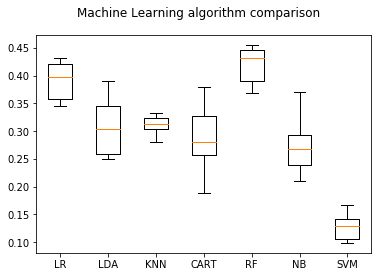

Wall time: 35.5 s


In [20]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Testing Process

In [21]:
tr_path = 'C:/Users/Nivedha/Documents/prediction3/images'

In [22]:
# get the training labels
tr_labels = os.listdir(tr_path)

# sort the training labels
tr_labels.sort()
print(tr_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [23]:
# get the training labels
tr_labels = os.listdir(tr_path)

# sort the training labels
tr_labels.sort()
print(tr_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [25]:
test_features = []
test_labels = []

In [26]:
# loop over the training data sub-folders
for tr_name in tr_labels:
    # join the training data path and each species training folder
    dir = os.path.join(tr_path + '/'+tr_name)
    print(dir)

    # get the current training label
    curr_label = tr_name
    print(curr_label)

    k = 1
    # loop over the images in each sub-folder
    for x in os.listdir(dir):
        if x.endswith(".jpg"):
            file=x
            print(file)
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(dir + '/' + file)
        print(file)
        print(image)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        glo = np.hstack([fv_histogram,fv_hu_moments])

        # update the list of labels and feature vectors
        test_labels.append(curr_label)
        test_features.append(glo)

        i += 1
        k += 1
    print ("[STATUS] processed folder: {}".format(curr_label))
    j += 1

print ("[STATUS] completed Global Feature Extraction...")

C:/Users/Nivedha/Documents/prediction3/images/0 Parade
0 Parade
parade1.jpg
parade1.jpg
[[[203 195 182]
  [189 181 168]
  [188 180 167]
  ...
  [142 153 151]
  [ 24  35  33]
  [ 15  26  24]]

 [[188 182 169]
  [180 174 161]
  [180 174 161]
  ...
  [ 38  49  47]
  [  2  13  11]
  [ 33  44  42]]

 [[191 190 176]
  [189 188 174]
  [186 185 171]
  ...
  [  0  11   9]
  [ 29  40  38]
  [ 46  57  55]]

 ...

 [[ 20  13  26]
  [ 25  21  33]
  [ 32  27  42]
  ...
  [ 91 117 153]
  [104 126 161]
  [ 87 106 139]]

 [[ 16   5  13]
  [ 30  22  29]
  [ 33  24  34]
  ...
  [ 81 108 145]
  [107 133 169]
  [ 97 119 155]]

 [[ 41  27  28]
  [ 65  51  53]
  [ 67  53  57]
  ...
  [ 99 128 167]
  [ 78 104 144]
  [ 94 120 157]]]
parade10.jpg
parade10.jpg
[[[104 101  96]
  [107 115 108]
  [110 134 126]
  ...
  [165 181 174]
  [164 181 178]
  [162 180 179]]

 [[ 82  87  86]
  [ 85  98  96]
  [ 86 113 110]
  ...
  [171 186 182]
  [170 187 184]
  [169 187 186]]

 [[ 75  87  97]
  [ 75  94 101]
  [ 72 101 108]


hs14.jpg
[[[216 186 145]
  [234 203 164]
  [244 215 178]
  ...
  [241 227 205]
  [241 227 205]
  [241 227 205]]

 [[216 186 145]
  [233 202 163]
  [244 215 178]
  ...
  [241 227 205]
  [241 227 205]
  [241 227 205]]

 [[216 186 145]
  [233 202 163]
  [244 215 178]
  ...
  [241 227 205]
  [241 227 205]
  [241 227 205]]

 ...

 [[240 230 223]
  [241 231 224]
  [242 232 225]
  ...
  [253 252 248]
  [253 252 248]
  [253 252 248]]

 [[241 231 224]
  [242 232 225]
  [242 232 225]
  ...
  [255 254 250]
  [255 254 250]
  [255 254 250]]

 [[242 232 225]
  [242 232 225]
  [242 232 225]
  ...
  [255 255 251]
  [255 255 251]
  [255 255 251]]]
hs15.jpg
hs15.jpg
[[[251 251 237]
  [251 251 237]
  [251 251 237]
  ...
  [ 30  11   4]
  [ 30  11   6]
  [ 31  12   7]]

 [[251 251 237]
  [251 251 237]
  [251 251 237]
  ...
  [ 29  10   3]
  [ 28   9   4]
  [ 28   9   4]]

 [[251 251 237]
  [251 251 237]
  [251 251 237]
  ...
  [ 29  10   3]
  [ 27   8   3]
  [ 26   7   2]]

 ...

 [[ 13   4   1]
  [ 13   

demo17.jpg
demo17.jpg
[[[135 222 224]
  [140 227 229]
  [146 233 235]
  ...
  [245 253 246]
  [245 253 246]
  [245 253 246]]

 [[156 239 241]
  [156 239 241]
  [154 238 243]
  ...
  [245 253 246]
  [245 253 246]
  [245 253 246]]

 [[138 215 218]
  [137 215 221]
  [140 218 224]
  ...
  [245 253 246]
  [245 253 246]
  [245 253 246]]

 ...

 [[ 87  83  65]
  [ 85  81  63]
  [ 79  77  59]
  ...
  [ 28  25  17]
  [ 31  25  18]
  [ 28  22  15]]

 [[ 49  49  33]
  [ 51  51  35]
  [ 55  55  39]
  ...
  [ 26  23  15]
  [ 29  23  16]
  [ 27  21  14]]

 [[ 69  72  57]
  [ 74  77  62]
  [ 80  83  68]
  ...
  [ 20  17   9]
  [ 24  18  11]
  [ 24  16   9]]]
demo18.jpg
demo18.jpg
[[[125 151 157]
  [116 142 148]
  [150 175 179]
  ...
  [123 135 139]
  [ 71  81  81]
  [ 84  93  90]]

 [[129 155 161]
  [112 138 144]
  [143 168 172]
  ...
  [202 214 218]
  [ 97 107 107]
  [ 93 102  99]]

 [[140 166 172]
  [116 142 148]
  [139 164 168]
  ...
  [187 199 201]
  [ 93 103 103]
  [103 114 112]]

 ...

 [[ 19  

[[[ 94  94 110]
  [ 87  88 102]
  [ 76  78  89]
  ...
  [ 86 111 181]
  [101 128 195]
  [109 137 201]]

 [[ 84  84 100]
  [ 77  78  92]
  [ 69  71  82]
  ...
  [ 91 114 182]
  [109 135 201]
  [118 146 210]]

 [[ 77  78  92]
  [ 72  73  87]
  [ 67  69  80]
  ...
  [ 95 117 183]
  [113 138 202]
  [121 146 210]]

 ...

 [[ 73 132 182]
  [ 74 133 183]
  [ 75 134 184]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[ 73 132 182]
  [ 74 133 183]
  [ 75 134 184]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[ 73 132 182]
  [ 74 133 183]
  [ 75 134 184]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]]
riot20.jpg
riot20.jpg
[[[179 184 182]
  [181 184 182]
  [178 181 179]
  ...
  [227 228 224]
  [228 229 227]
  [230 231 229]]

 [[176 181 179]
  [179 182 180]
  [178 181 179]
  ...
  [225 226 222]
  [225 226 224]
  [227 228 226]]

 [[207 210 208]
  [204 207 205]
  [199 202 200]
  ...
  [225 226 222]
  [225 226 222]
  [226 227 223]]

 ...

 [[167 166 168]
  [163 162 164

cheer7.jpg
[[[236 215 247]
  [247 224 255]
  [253 229 255]
  ...
  [255 237 255]
  [242 218 248]
  [219 186 220]]

 [[238 217 249]
  [247 225 254]
  [251 229 255]
  ...
  [255 235 255]
  [244 218 248]
  [222 187 221]]

 [[238 218 247]
  [247 225 254]
  [250 228 255]
  ...
  [245 219 249]
  [231 200 231]
  [205 168 202]]

 ...

 [[255 254 253]
  [254 255 253]
  [249 255 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 252]
  [251 255 252]
  [244 255 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 252]
  [251 255 252]
  [243 255 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
cheer8.jpg
cheer8.jpg
[[[241 199 170]
  [241 199 170]
  [241 199 170]
  ...
  [239 199 170]
  [239 199 170]
  [238 198 169]]

 [[241 199 170]
  [241 199 170]
  [242 200 171]
  ...
  [239 199 170]
  [239 199 170]
  [239 199 170]]

 [[241 199 170]
  [242 200 171]
  [242 200 171]
  ...
  [240 200 171]
  [240 200 171]
  [239 199 170]]

 ...

 [[230 251 253]
  [

sc12.jpg
sc12.jpg
[[[111 163 116]
  [112 164 117]
  [114 166 119]
  ...
  [ 76 165 199]
  [ 78 165 197]
  [ 83 166 198]]

 [[112 164 117]
  [113 165 118]
  [115 167 120]
  ...
  [ 78 165 197]
  [ 80 165 197]
  [ 84 165 198]]

 [[113 165 118]
  [113 165 118]
  [113 167 120]
  ...
  [ 80 165 197]
  [ 83 165 196]
  [ 85 165 196]]

 ...

 [[107 154 146]
  [111 158 150]
  [117 164 156]
  ...
  [ 91 147 134]
  [ 90 146 133]
  [ 89 145 132]]

 [[105 152 144]
  [108 155 147]
  [114 161 153]
  ...
  [ 90 146 133]
  [ 90 146 133]
  [ 90 146 133]]

 [[104 151 143]
  [107 154 146]
  [112 159 151]
  ...
  [ 89 145 132]
  [ 90 146 133]
  [ 91 147 134]]]
sc13.jpg
sc13.jpg
[[[ 0  1  0]
  [ 0  1  0]
  [ 1  2  0]
  ...
  [ 2  2  2]
  [ 2  2  2]
  [ 3  3  3]]

 [[ 0  1  0]
  [ 0  1  0]
  [ 1  2  0]
  ...
  [ 2  2  2]
  [ 2  2  2]
  [ 3  3  3]]

 [[ 0  1  0]
  [ 0  1  0]
  [ 1  2  0]
  ...
  [ 2  2  2]
  [ 2  2  2]
  [ 3  3  3]]

 ...

 [[ 0 88 45]
  [ 0 87 44]
  [ 0 87 44]
  ...
  [ 2 74 31]
  [ 1 73 30]

In [27]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(test_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(test_labels).shape))

[STATUS] feature vector size (140, 519)
[STATUS] training Labels (140,)
Wall time: 1.99 ms


In [28]:
testNames = np.unique(test_labels)
print(testNames)
les = LabelEncoder()
test = les.fit_transform(test_labels)
print(test)
print ("[STATUS] training labels encoded...")

['0 Parade' '1 Handshaking' '2 Demonstration' '3 Riot' '4 Cheering'
 '5 Shoppers' '6 Soccer']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[STATUS] training labels encoded...


In [29]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
print(scaler1)
rescaledtest_features = scaler.transform(test_features)
print(rescaledtest_features)
print ("[STATUS] feature vector normalized...")

MinMaxScaler(copy=True, feature_range=(0, 1))
[[2.14107368e-03 2.16558973e-02 3.28608942e-02 ... 1.82238380e-01
  5.55857776e-01 8.72043823e-01]
 [1.04321057e-02 1.35949373e-02 2.41714159e-02 ... 1.82243746e-01
  5.55795537e-01 8.72034804e-01]
 [1.58507409e-02 5.36246548e-01 7.69445994e-02 ... 1.82238656e-01
  5.55893249e-01 8.72043111e-01]
 ...
 [9.47117910e-03 2.26273648e-02 2.67541652e-02 ... 1.82263758e-01
  5.55305877e-01 8.72033731e-01]
 [9.81544449e-01 1.32029292e-03 6.48239471e-05 ... 1.97232680e-01
  7.00599597e-01 8.69509962e-01]
 [1.45849043e-03 3.81047078e-03 1.65246885e-03 ... 1.82238723e-01
  5.55880591e-01 8.72043268e-01]]
[STATUS] feature vector normalized...


In [31]:
h5f_datatest = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/test_globalfeaturesmodel1.h5', 'w')
h5f_datatest.create_dataset('dataset_003', data=np.array(rescaledtest_features))

<HDF5 dataset "dataset_003": shape (140, 519), type "<f8">

In [32]:
h5f_labeltest = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/globaltest_labelsmodel1.h5', 'w')
h5f_labeltest.create_dataset('dataset_004', data=np.array(test))

<HDF5 dataset "dataset_004": shape (140,), type "<i8">

In [33]:
h5f_datatest.close()
h5f_labeltest.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [34]:
h5f_datatest = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/test_globalfeaturesmodel1.h5', 'r')
h5f_labeltest = h5py.File('C:/Users/Nivedha/Documents/dataset_prac/globaltest_labelsmodel1.h5', 'r')

test_global_features_string = h5f_datatest['dataset_003']
test_global_labels_string = h5f_labeltest['dataset_004']

test_features = np.array(test_global_features_string)
test_global_labels = np.array(test_global_labels_string)

h5f_datatest.close()
h5f_labeltest.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(test_features.shape))
print ("[STATUS] labels shape: {}".format(test_global_labels.shape))

[STATUS] features shape: (140, 519)
[STATUS] labels shape: (140,)


In [35]:
test_data = np.array(test_features)
test_labels = np.array(test_global_labels)

In [36]:
for name, model in models:
    model.fit(trainDataGlobal, trainLabelsGlobal)

    ypred = model.predict(test_data)

    #print("\nLinear SVC Accuracy (Ten-Fold CV):", cross_val_score(model, features, labels, cv=10).mean(), "\n")

    print("Accuracy (Holdout Set):", accuracy_score(test_labels, ypred), "\n")

Accuracy (Holdout Set): 0.4 

Accuracy (Holdout Set): 0.30714285714285716 

Accuracy (Holdout Set): 0.29285714285714287 

Accuracy (Holdout Set): 0.29285714285714287 

Accuracy (Holdout Set): 0.5214285714285715 

Accuracy (Holdout Set): 0.2857142857142857 

Accuracy (Holdout Set): 0.14285714285714285 



In [37]:
model1= RandomForestClassifier(n_estimators=num_trees, random_state=9)
model1.fit(trainDataGlobal, trainLabelsGlobal)
ypred1 = model1.predict(test_data)

In [38]:
print(ypred1)

[0 6 5 5 0 0 5 0 2 1 0 2 2 2 0 2 5 5 0 2 1 1 3 1 6 1 1 1 1 1 4 4 1 1 1 1 1
 2 3 1 2 2 5 2 2 2 3 2 3 2 5 0 2 3 2 5 1 2 1 1 3 3 1 3 3 5 0 1 0 4 3 3 2 3
 3 3 3 2 1 3 4 6 3 6 6 6 6 4 3 5 0 3 4 5 2 4 1 4 6 5 3 4 5 0 5 4 5 2 2 4 2
 0 3 2 5 5 3 5 5 1 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [39]:
print(classification_report(test_labels, ypred1))

             precision    recall  f1-score   support

          0       0.50      0.35      0.41        20
          1       0.61      0.70      0.65        20
          2       0.42      0.50      0.45        20
          3       0.50      0.55      0.52        20
          4       0.45      0.25      0.32        20
          5       0.37      0.35      0.36        20
          6       0.70      0.95      0.81        20

avg / total       0.51      0.52      0.50       140



[INFO] confusion matrix


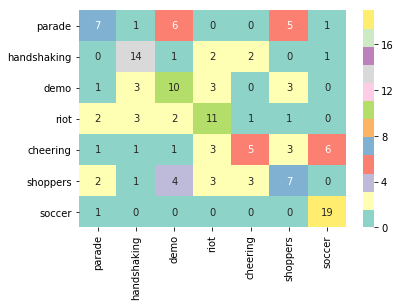

In [40]:
# display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
print ("[INFO] confusion matrix")

# get the list of training lables
labels = sorted(list(os.listdir(tr_path)))

# plot the confusion matrix
cm = confusion_matrix(test_labels, ypred1)
cm_df = pd.DataFrame(cm,
                     index = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'], 
                     columns = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'])
sns.heatmap(cm_df,
            annot=True,
            cmap="Set3")

plt.show()